In [1]:
!pip install -q tonic snntorch tqdm matplotlib
!pip install -qU snntorch

import os, random, gc, time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

import tonic
import tonic.transforms as transforms
import snntorch as snn
import snntorch.surrogate as surrogate

# -----------------------
# Reproducibility
# -----------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# -----------------------
# ROI gating controls
# -----------------------
ROI_USE_PERCENTILE = True   # use percentile-based gating (recommended)
ROI_PERCENTILE     = 0.15   # keep top 15% mask activations per (batch, time, frame)
ROI_THRESHOLD      = 0.3    # used only if ROI_USE_PERCENTILE = False
ROI_TRAINABLE      = False  # keep ROI frozen unless you explicitly want to learn it

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.2/106.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.1/125.1 kB 7.7 MB/s eta 0:00:00
Device: cuda


In [2]:
class ToFloat:
    def __call__(self, frames):
        # Tonic -> numpy array by default; convert to float tensor
        return torch.tensor(frames, dtype=torch.float32)

class MergePolarities:
    def __call__(self, frames):
        # (T, 2, H, W) -> (T, 1, H, W)
        if isinstance(frames, torch.Tensor):
            return frames.sum(dim=1, keepdim=True)
        else:
            return torch.tensor(frames).sum(dim=1, keepdim=True)

In [3]:
sensor_size_nm = tonic.datasets.NMNIST.sensor_size
N_TIME_BINS = 8  

transform = transforms.Compose([
    transforms.ToFrame(sensor_size=sensor_size_nm, n_time_bins=N_TIME_BINS),
    ToFloat(),
    MergePolarities()
])

trainset_nm = tonic.datasets.NMNIST(save_to='./data', train=True,  transform=transform)
testset_nm  = tonic.datasets.NMNIST(save_to='./data', train=False, transform=transform)

batch_size = 64
trainloader_nm = DataLoader(trainset_nm, batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=True)
testloader_nm  = DataLoader(testset_nm,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print("Train batches:", len(trainloader_nm), " Test batches:", len(testloader_nm))

  0%|          | 0/1011893601 [00:00<?, ?it/s]

Extracting ./data/NMNIST/train.zip to ./data/NMNIST


  0%|          | 0/169674850 [00:00<?, ?it/s]

Extracting ./data/NMNIST/test.zip to ./data/NMNIST
Train batches: 938  Test batches: 157


In [4]:
class SpikingRNNROI_Temporal(nn.Module):
    """
    Temporal spiking ROI (Lite):
    - Downsample input (H/2, W/2) → small spiking conv stack → 1x1 conv → upsample mask.
    - Detaches membrane every step to stop graph growth across time.
    """
    def __init__(self, input_channels=1):
        super().__init__()
        self.ds = nn.AvgPool2d(kernel_size=2, stride=2)  # downsample

        self.conv1 = nn.Conv2d(input_channels, 8, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(8)
        self.lif1  = snn.Leaky(beta=0.9, spike_grad=surrogate.atan())

        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(16)
        self.lif2  = snn.Leaky(beta=0.9, spike_grad=surrogate.atan())

        self.mask_conv = nn.Conv2d(16, 1, kernel_size=1)
        self.sig       = nn.Sigmoid()

    def forward(self, x_seq):
        # x_seq: (B, T, C, H, W)
        B, T, C, H, W = x_seq.shape
        masks = []
        mem1 = mem2 = None

        for t in range(T):
            x_t = x_seq[:, t]             # (B,1,H,W)
            x_t = self.ds(x_t)            # (B,1,H/2,W/2)

            spk1, mem1 = self.lif1(self.bn1(self.conv1(x_t)), mem1)
            mem1 = mem1.detach()
            spk2, mem2 = self.lif2(self.bn2(self.conv2(spk1)), mem2)
            mem2 = mem2.detach()

            lowmask = self.sig(self.mask_conv(spk2))                  # (B,1,H/2,W/2)
            mask = torch.nn.functional.interpolate(lowmask, size=(H, W), mode="bilinear", align_corners=False)
            masks.append(mask)

        return torch.stack(masks, dim=1)  # (B,T,1,H,W)

def apply_roi_filter(events, masks, threshold=ROI_THRESHOLD, percentile=None):
    """
    events: (B,T,1,H,W), masks: (B,T,1,H,W)
    - If percentile is None: keep masks > threshold (absolute).
    - Else: keep top p% per (B,T) frame via kthvalue.
    """
    if percentile is None:
        return events * (masks > threshold)

    B, T, C, H, W = masks.shape
    flat = masks.reshape(B, T, C, H*W)

    k = max(1, int(round((1.0 - float(percentile)) * (H*W))))
    thr_vals = torch.kthvalue(flat, k, dim=3).values  # (B,T,C)
    thr = thr_vals.reshape(B, T, C, 1, 1)

    return events * (masks >= thr)

In [5]:
# Instantiate ROI (temporal only) BEFORE any use
roi_temporal = SpikingRNNROI_Temporal().to(device)

# Quick single-batch sanity check to confirm filtering is active
with torch.no_grad():
    data, _ = next(iter(trainloader_nm))
    data = data.to(device)
    masks = roi_temporal(data)

    filtered = apply_roi_filter(
        data, masks,
        percentile=(ROI_PERCENTILE if ROI_USE_PERCENTILE else None),
        threshold=ROI_THRESHOLD
    )

    before = (data > 0).float().mean().item()
    after  = (filtered > 0).float().mean().item()
    reduction = 100.0 * (before - after) / max(before, 1e-9)
    print(f"Non-zero fraction BEFORE: {before:.4f}")
    print(f"Non-zero fraction AFTER : {after:.4f}")
    print(f"Event reduction        : {reduction:.2f}%")

Non-zero fraction BEFORE: 0.1585
Non-zero fraction AFTER : 0.0048
Event reduction        : 96.98%


In [6]:
class LeNetCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool  = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class LeNetSNN(nn.Module):
    """LeNet-style SNN with spiking hidden layers and linear readout."""
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool  = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, num_classes)   # linear readout

        self.lif1 = snn.Leaky(beta=0.9)
        self.lif2 = snn.Leaky(beta=0.9)
        self.lif3 = snn.Leaky(beta=0.9)
        self.lif4 = snn.Leaky(beta=0.9)

    def forward(self, x_seq):
        # x_seq: (B, T, 1, H, W)
        B, T, _, _, _ = x_seq.shape
        mem1 = mem2 = mem3 = mem4 = None

        # ✅ tensor accumulator (no Python float), lives on the right device/dtype
        sum_logits = torch.zeros(B, self.fc3.out_features,
                                 device=x_seq.device, dtype=x_seq.dtype)

        for t in range(T):
            x_t = x_seq[:, t]                        # (B,1,H,W)

            spk1, mem1 = self.lif1(self.conv1(x_t), mem1);  mem1 = mem1.detach()
            x_t = self.pool(spk1)

            spk2, mem2 = self.lif2(self.conv2(x_t), mem2);  mem2 = mem2.detach()
            x_t = self.pool(spk2)
            x_t = torch.flatten(x_t, 1)

            spk3, mem3 = self.lif3(self.fc1(x_t), mem3);    mem3 = mem3.detach()
            spk4, mem4 = self.lif4(self.fc2(spk3), mem4);   mem4 = mem4.detach()

            logits_t = self.fc3(spk4)                       # linear readout
            sum_logits = sum_logits + logits_t              # accumulate as tensor

        return sum_logits / T

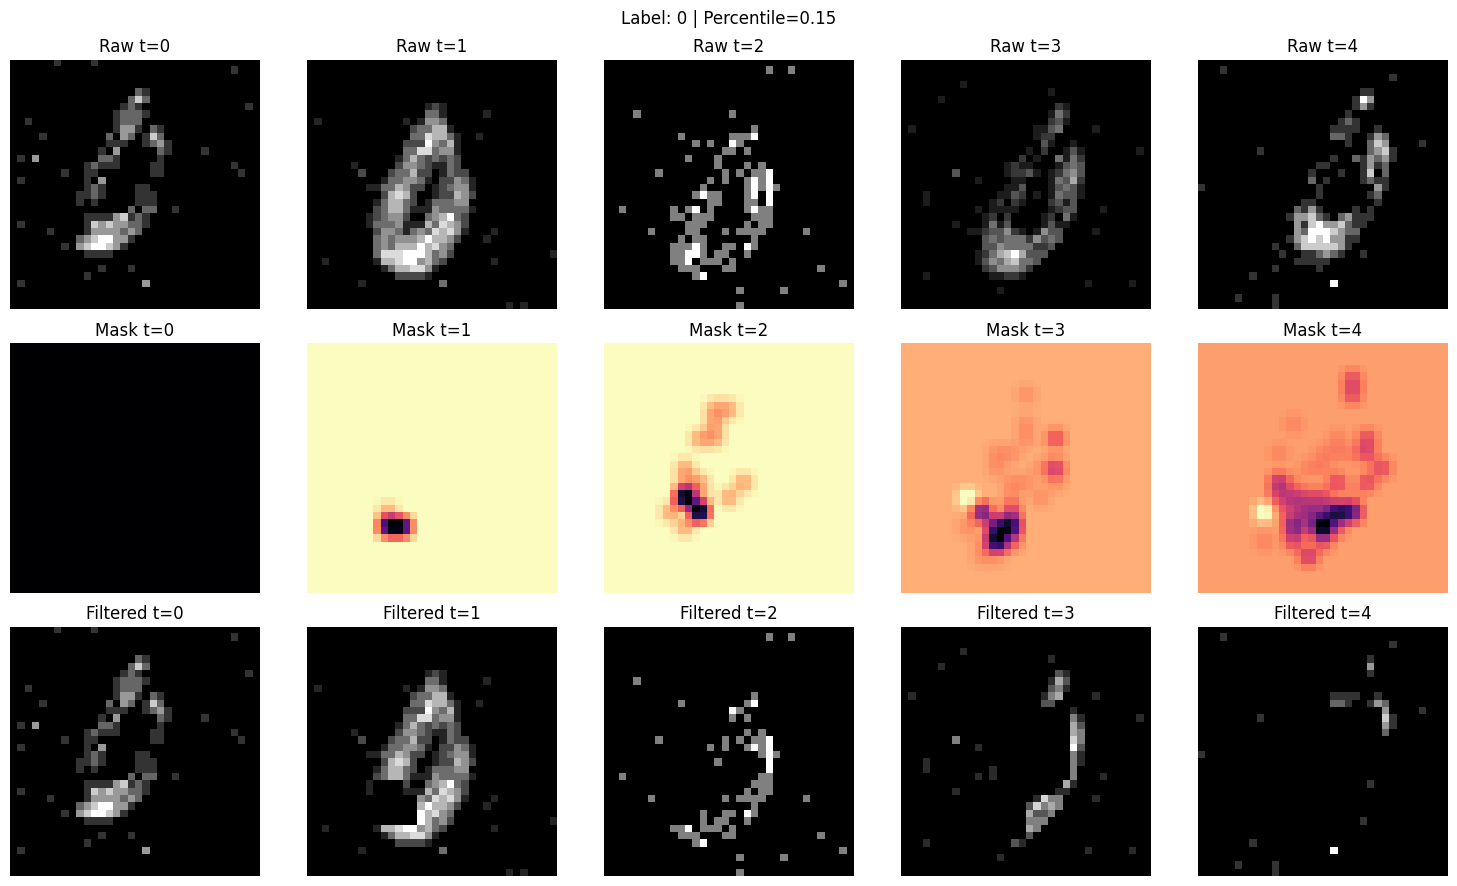

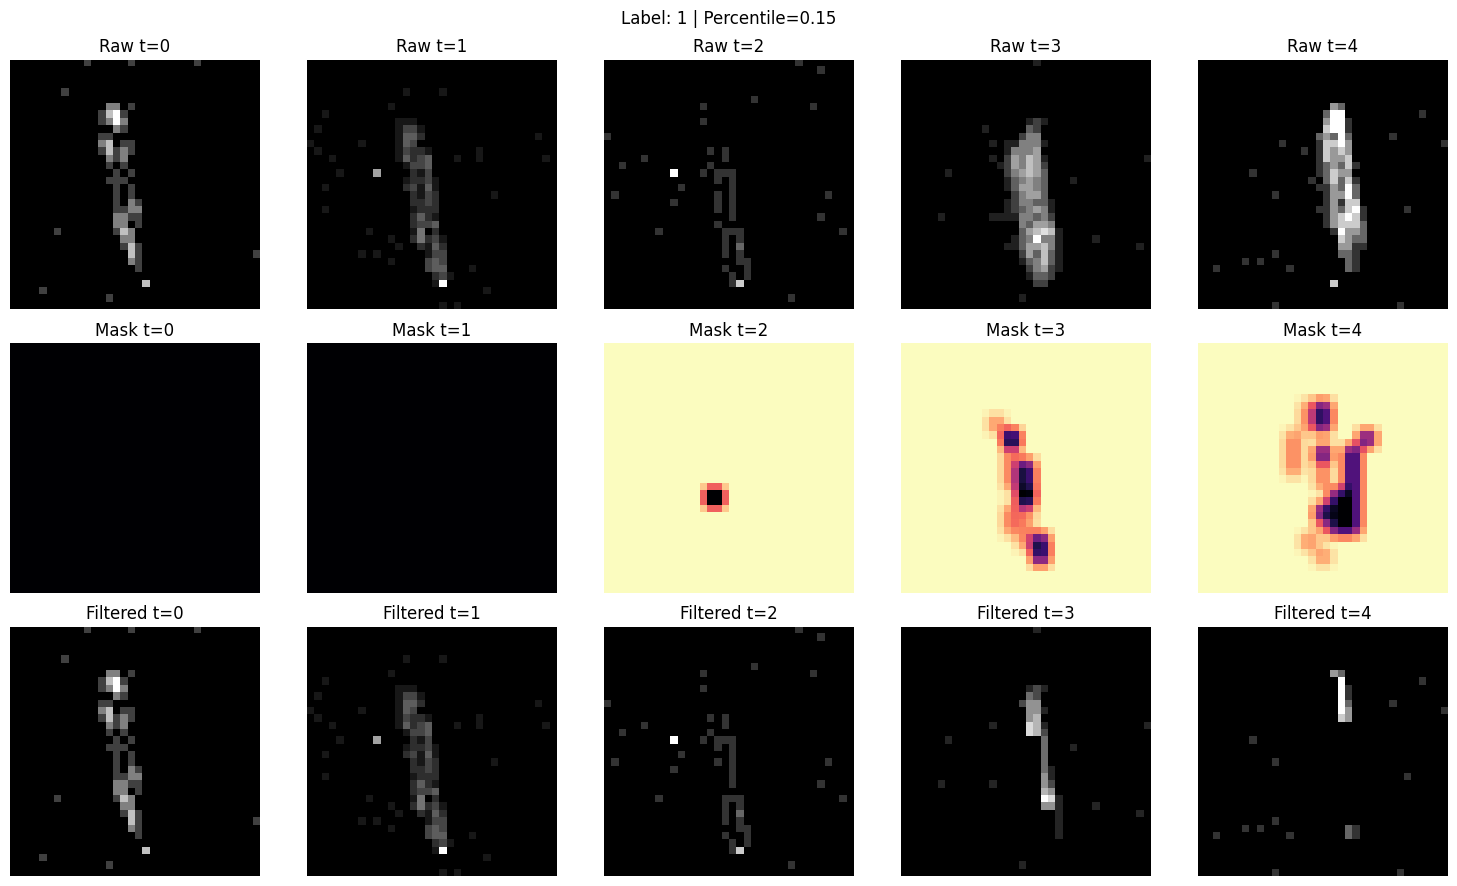

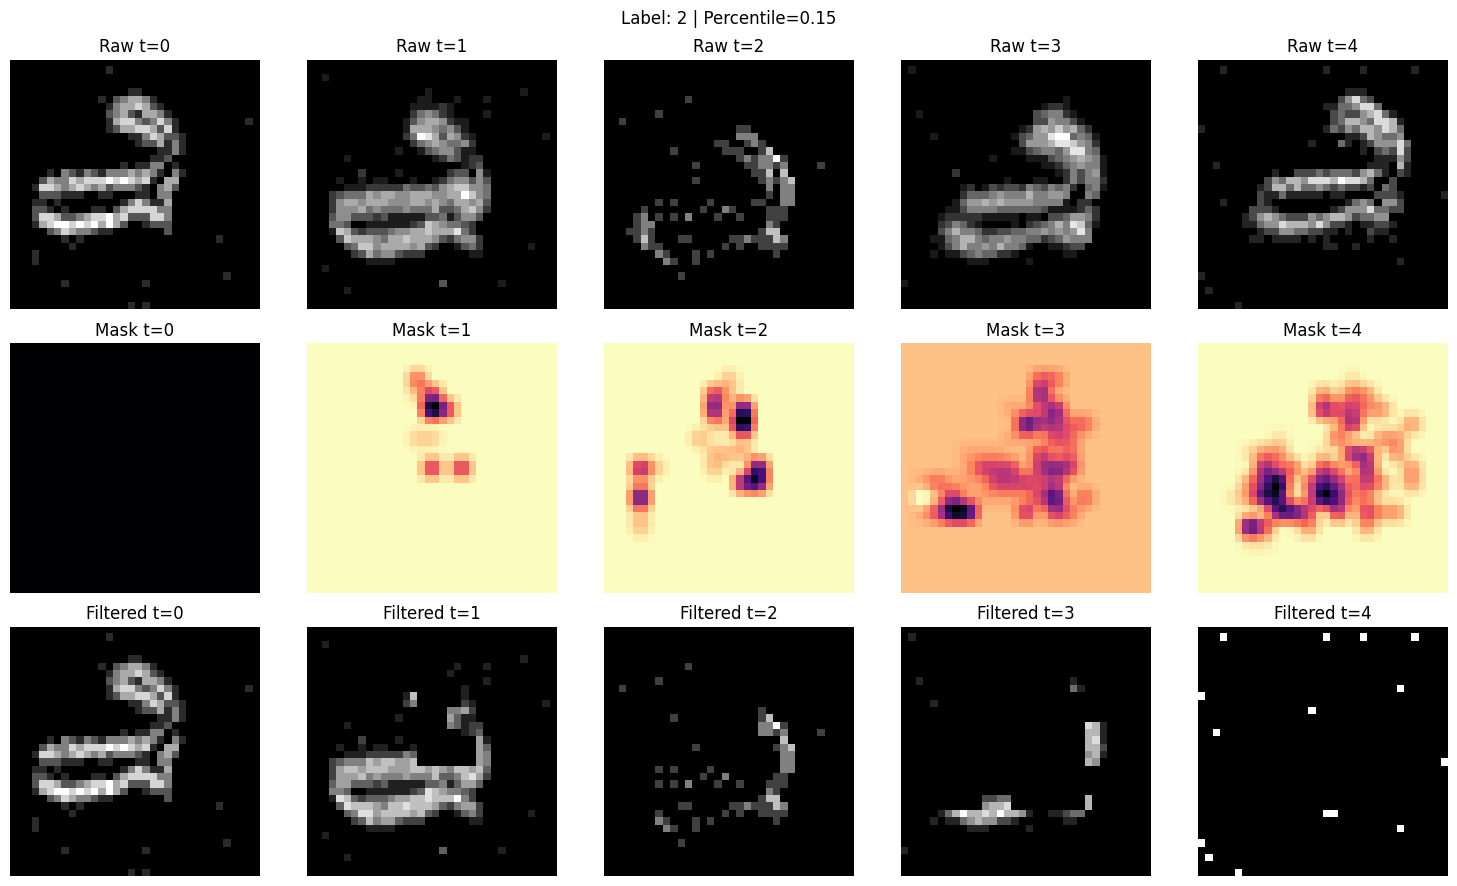

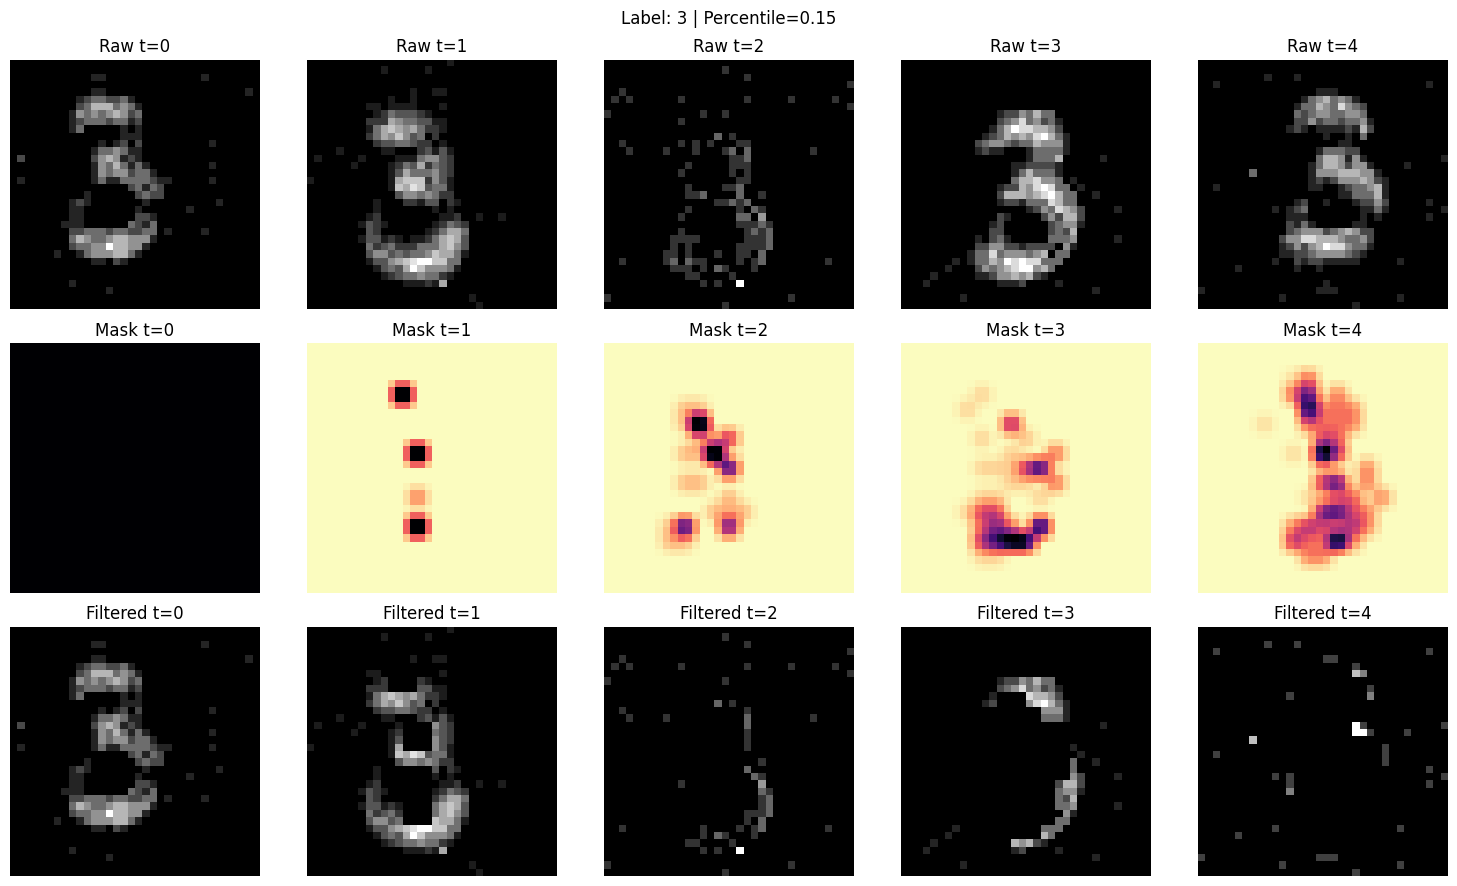

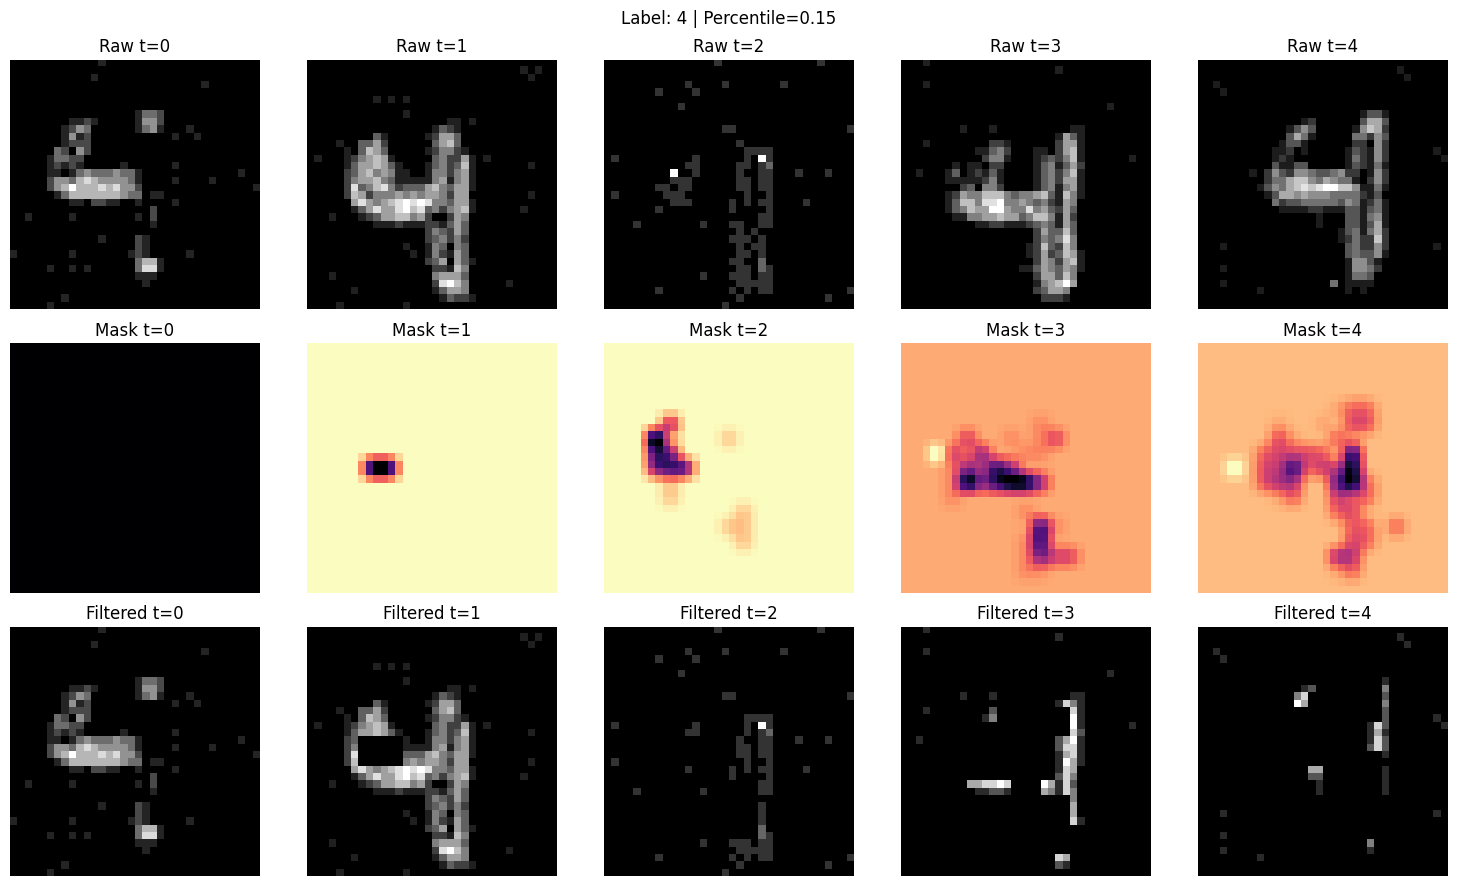

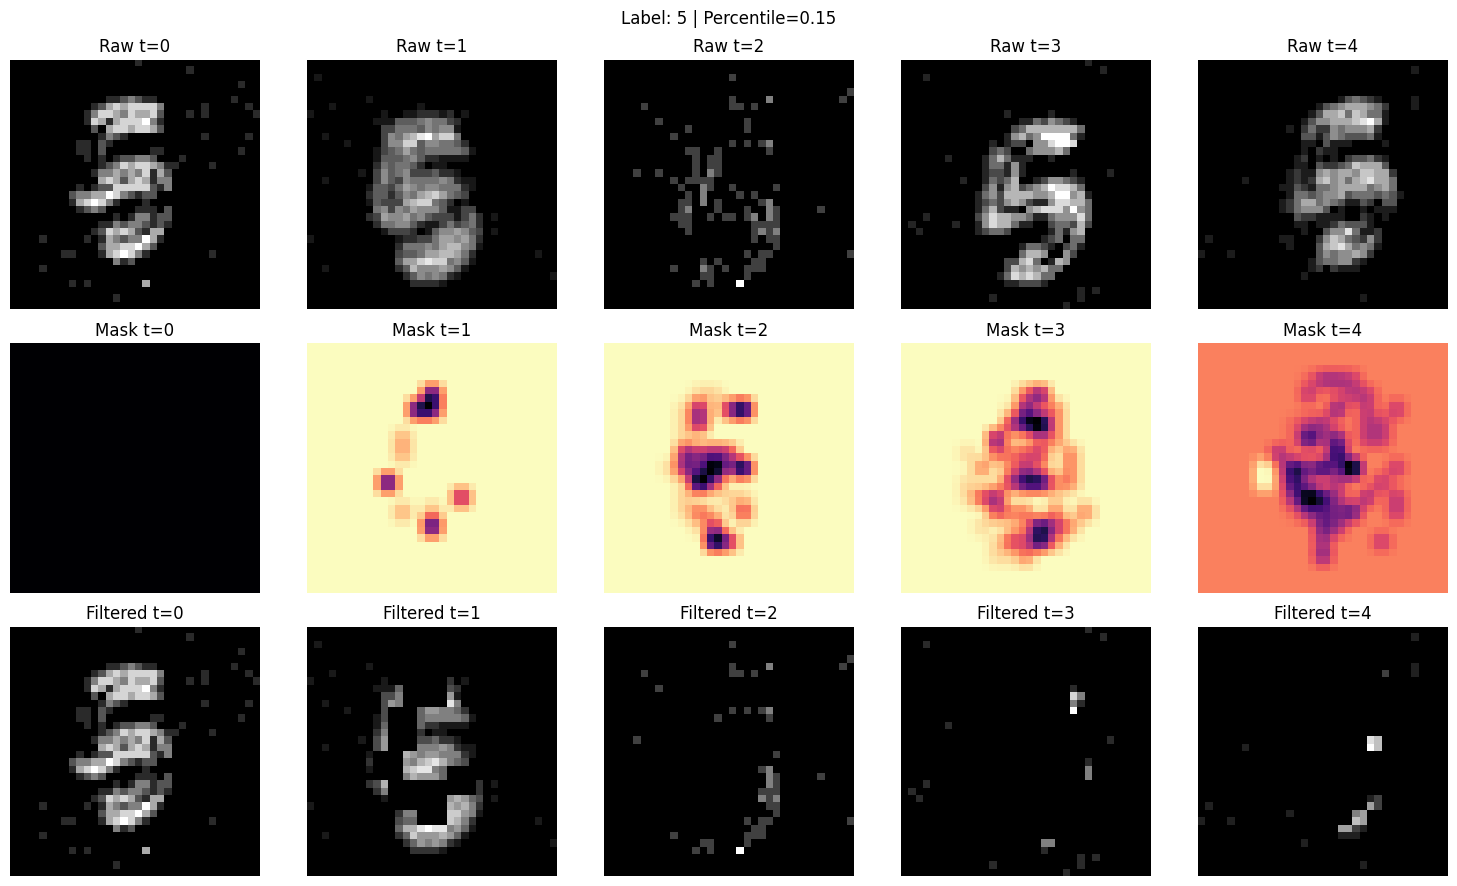

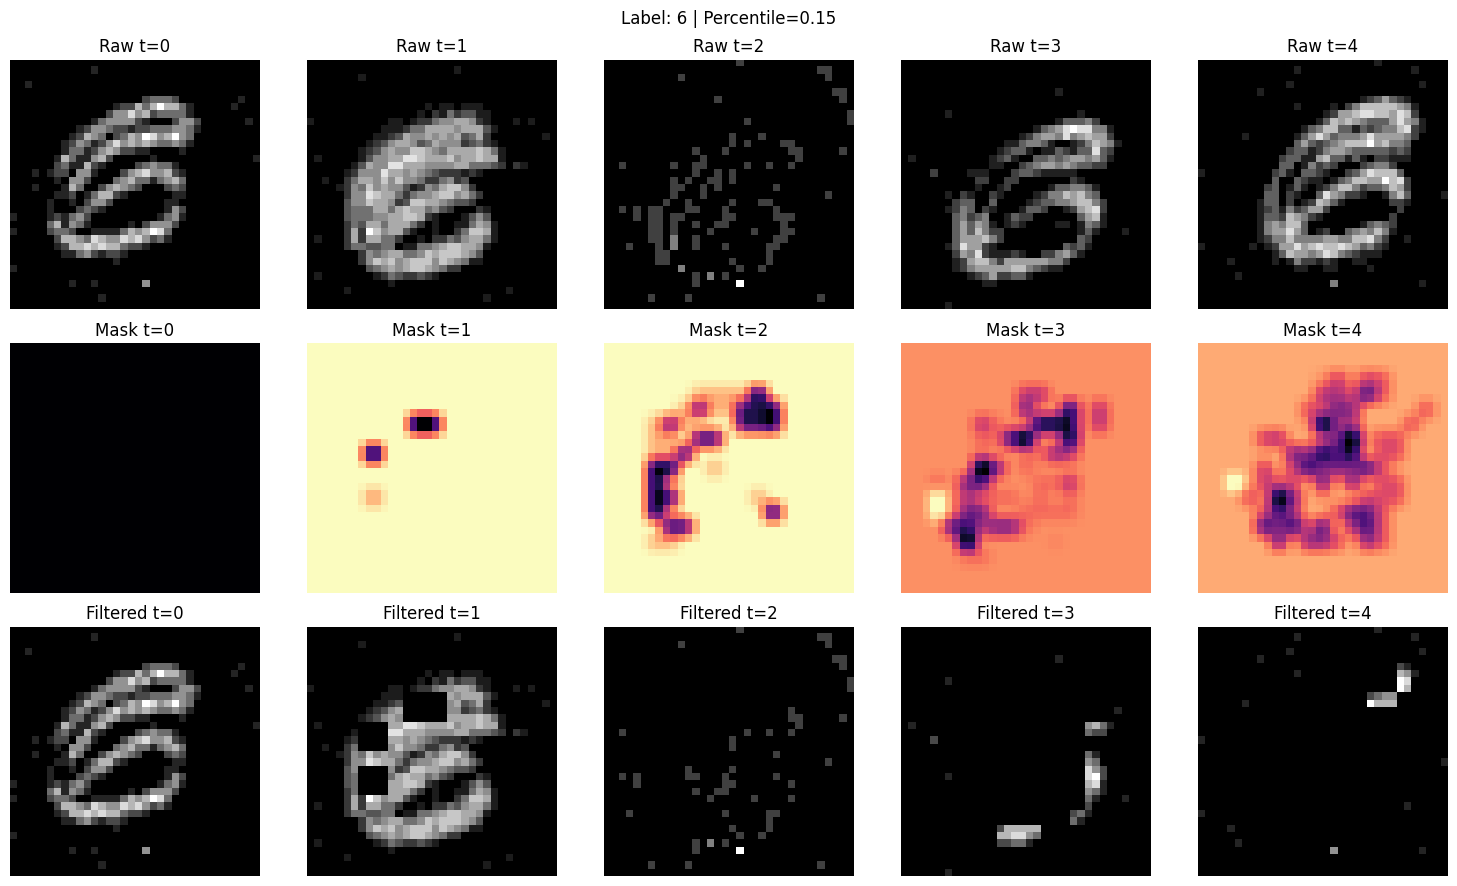

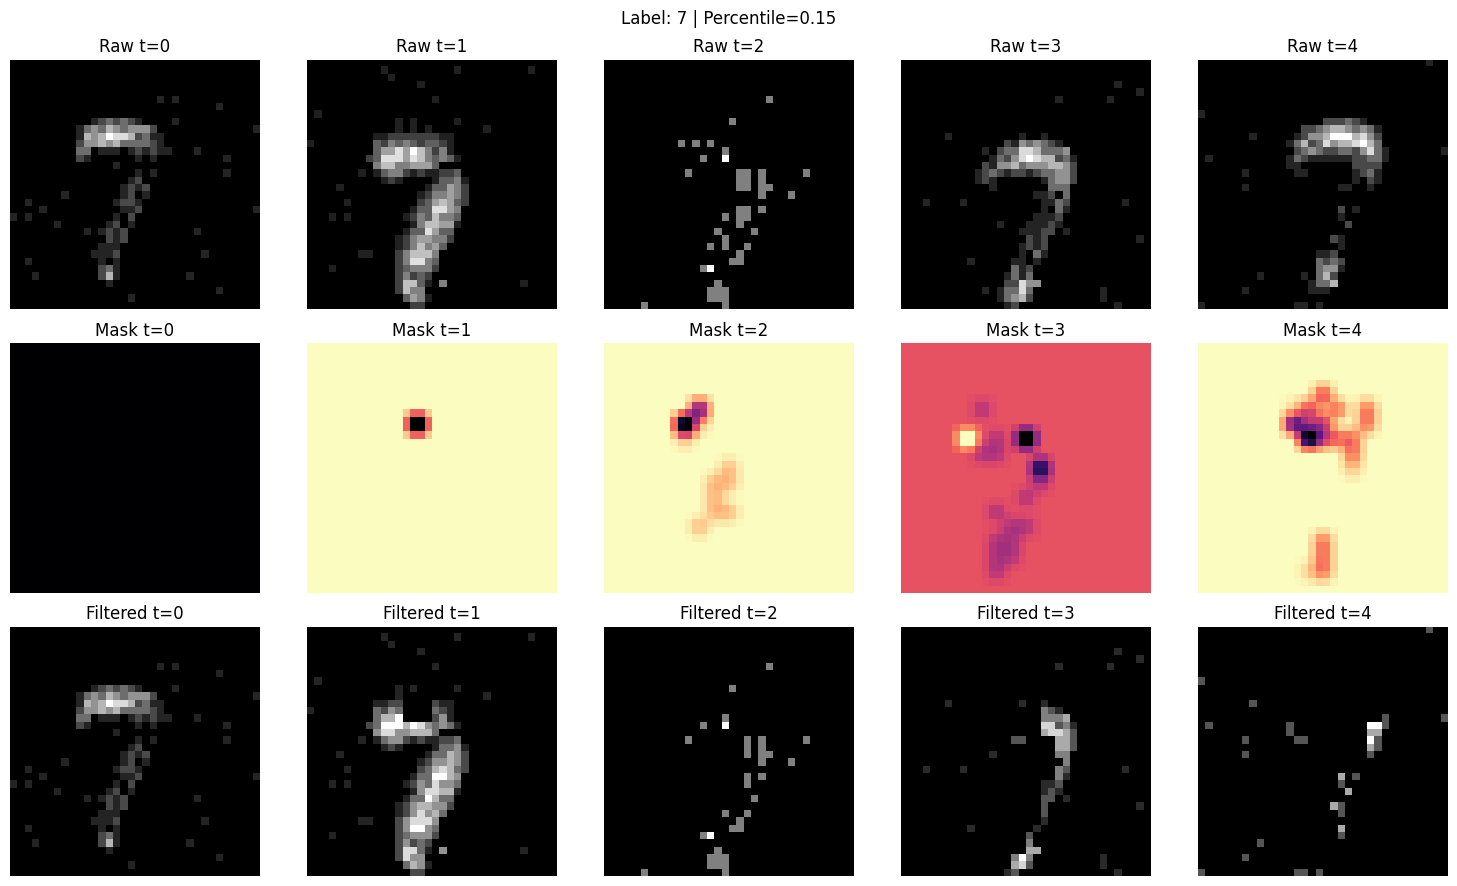

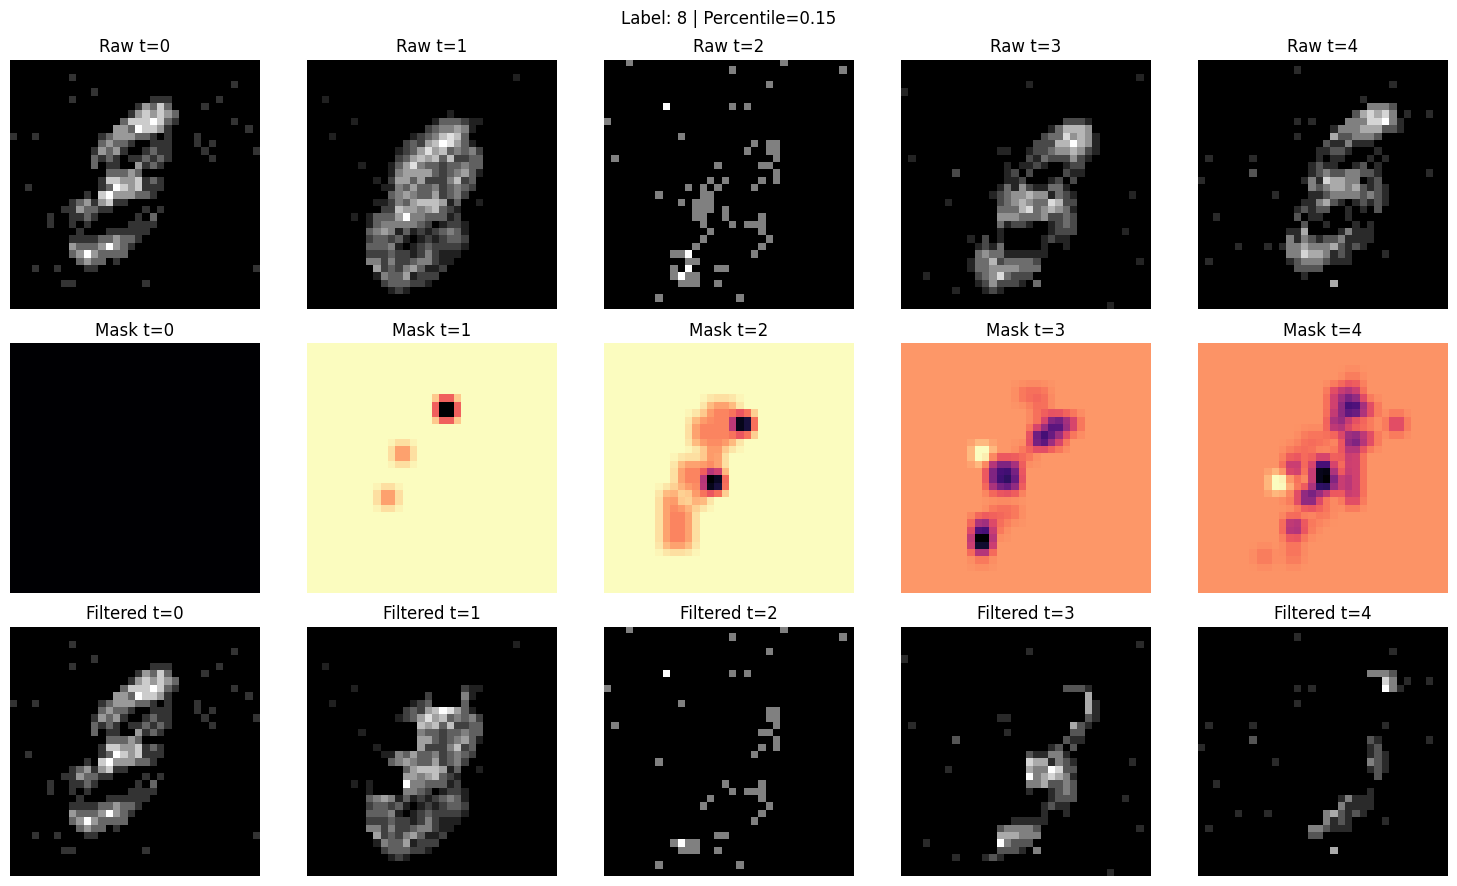

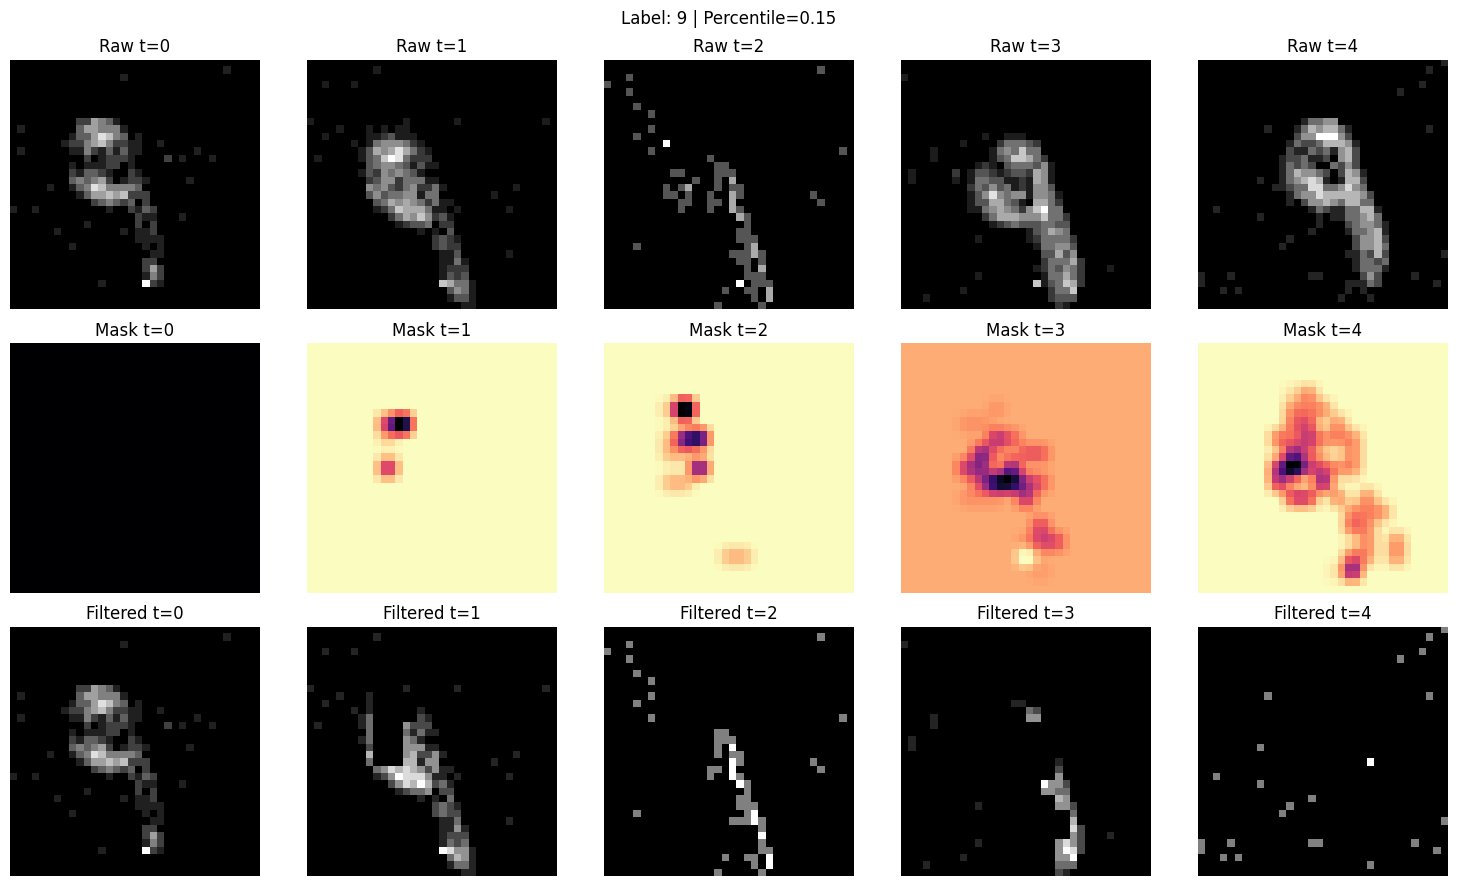

In [7]:
def get_fixed_samples_by_label(loader, num_labels=10):
    found = {}
    for data, targets in loader:
        for i in range(data.size(0)):
            lbl = targets[i].item()
            if lbl not in found:
                found[lbl] = data[i]
                if len(found) >= num_labels:
                    break
        if len(found) >= num_labels:
            break
    labels = sorted(found.keys())
    data_tensor = torch.stack([found[l] for l in labels], dim=0)  # (L,T,C,H,W)
    return data_tensor, torch.tensor(labels)

@torch.no_grad()
def preview_raw_vs_filtered(loader, roi_model, max_digits=10, time_steps_to_show=5):
    roi_model.eval()
    raw, labels = get_fixed_samples_by_label(loader, num_labels=max_digits)
    raw_dev = raw.to(device)
    masks = roi_model(raw_dev)
    if ROI_USE_PERCENTILE:
        filt_dev = apply_roi_filter(raw_dev, masks, percentile=ROI_PERCENTILE)
        caption = f"Percentile={ROI_PERCENTILE:.2f}"
    else:
        filt_dev = apply_roi_filter(raw_dev, masks, threshold=ROI_THRESHOLD)
        caption = f"Threshold={ROI_THRESHOLD:.2f}"
    filtered = filt_dev.cpu()

    L, T, C, H, W = raw.shape
    cols = min(time_steps_to_show, T)
    for idx in range(L):
        fig, axes = plt.subplots(3, cols, figsize=(3*cols, 9))
        for t in range(cols):
            axes[0, t].imshow(raw[idx, t, 0], cmap='gray');      axes[0, t].set_title(f"Raw t={t}"); axes[0, t].axis('off')
            axes[1, t].imshow(masks[idx, t, 0].cpu(), cmap='magma'); axes[1, t].set_title(f"Mask t={t}"); axes[1, t].axis('off')
            axes[2, t].imshow(filtered[idx, t, 0], cmap='gray'); axes[2, t].set_title(f"Filtered t={t}"); axes[2, t].axis('off')
        plt.suptitle(f"Label: {labels[idx].item()} | {caption}")
        plt.tight_layout()
        plt.show()

roi_temporal = SpikingRNNROI_Temporal().to(device)
preview_raw_vs_filtered(trainloader_nm, roi_temporal, max_digits=10, time_steps_to_show=5)

In [8]:
def count_events(data):
    return (data > 0).sum().item()

def train_epoch(model, loader, criterion, optimizer, is_snn=False,
                roi_model=None, threshold=0.0, percentile=None, tag=None):
    model.train()
    if roi_model is not None:
        roi_model.train() if ROI_TRAINABLE else roi_model.eval()

    if is_snn:
        try:
            snn.Leaky.reset_hidden()
        except Exception:
            pass
            
    running_loss, correct, total = 0.0, 0, 0
    reductions, batch_times = [], []

    for data, targets in tqdm(loader, desc=f"Training[{tag}]" if tag else "Training", leave=False):
        if is_snn:
            try:
                snn.Leaky.detach_hidden()  # global detach
            except Exception:
                pass
        start = time.time()
        data    = data.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        if roi_model is not None:
            if ROI_TRAINABLE:
                masks = roi_model(data)
            else:
                with torch.no_grad():
                    masks = roi_model(data)
            before = count_events(data)
            data   = apply_roi_filter(data, masks, threshold=threshold, percentile=percentile)
            after  = count_events(data)
            reductions.append(100*(before-after)/max(before,1))

        optimizer.zero_grad(set_to_none=True)
        x = data if is_snn else data.mean(dim=1)
        outputs = model(x)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += float(loss.item())
        _, pred = outputs.max(1)
        total   += targets.size(0)
        correct += int(pred.eq(targets).sum().item())
        batch_times.append(time.time() - start)

        del outputs, loss, x, data, targets
        if roi_model is not None:
            del masks
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    avg_red = sum(reductions)/len(reductions) if reductions else 0.0
    avg_bt  = sum(batch_times)/len(batch_times) if batch_times else 0.0
    return running_loss/max(len(loader),1), 100.0*correct/max(total,1), avg_red, avg_bt

@torch.no_grad()
def test_epoch(model, loader, criterion, is_snn=False,
               roi_model=None, threshold=0.0, percentile=None, tag=None):
    model.eval()
    if roi_model is not None:
        roi_model.eval()

    if is_snn:
        try:
            snn.Leaky.reset_hidden()
        except Exception:
            pass     

    running_loss, correct, total = 0.0, 0, 0
    reductions, batch_times = [], []

    for data, targets in tqdm(loader, desc=f"Testing[{tag}]" if tag else "Testing", leave=False):
        if is_snn:
            try:
                snn.Leaky.detach_hidden()  # global detach
            except Exception:
                pass
                
        start = time.time()
        data    = data.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        if roi_model is not None:
            masks = roi_model(data)
            before = count_events(data)
            data   = apply_roi_filter(data, masks, threshold=threshold, percentile=percentile)
            after  = count_events(data)
            reductions.append(100*(before-after)/max(before,1))

        x = data if is_snn else data.mean(dim=1)
        outputs = model(x)
        loss = criterion(outputs, targets)

        running_loss += float(loss.item())
        _, pred = outputs.max(1)
        total   += targets.size(0)
        correct += int(pred.eq(targets).sum().item())
        batch_times.append(time.time() - start)

        del outputs, loss, x, data, targets
        if roi_model is not None:
            del masks
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    avg_red = sum(reductions)/len(reductions) if reductions else 0.0
    avg_bt  = sum(batch_times)/len(batch_times) if batch_times else 0.0
    return running_loss/max(len(loader),1), 100.0*correct/max(total,1), avg_red, avg_bt

class EarlyStopper:
    def __init__(self, patience=3):
        self.patience  = patience
        self.counter   = 0
        self.best_acc  = -1e9
    def step(self, acc):
        if acc > self.best_acc + 1e-6:
            self.best_acc = acc
            self.counter  = 0
            return False
        self.counter += 1
        return self.counter >= self.patience


=== CNN_Full ===


[CNN_Full] Epoch 1: Test Acc 91.57% | Red 0.00% | Batch 1.7 ms


[CNN_Full] Epoch 2: Test Acc 94.11% | Red 0.00% | Batch 1.7 ms


[CNN_Full] Epoch 3: Test Acc 93.97% | Red 0.00% | Batch 1.6 ms


[CNN_Full] Epoch 4: Test Acc 94.94% | Red 0.00% | Batch 1.8 ms


[CNN_Full] Epoch 5: Test Acc 95.74% | Red 0.00% | Batch 1.7 ms


[CNN_Full] Epoch 6: Test Acc 96.14% | Red 0.00% | Batch 1.8 ms


[CNN_Full] Epoch 7: Test Acc 96.51% | Red 0.00% | Batch 1.6 ms


[CNN_Full] Epoch 8: Test Acc 96.74% | Red 0.00% | Batch 1.7 ms


[CNN_Full] Epoch 9: Test Acc 97.33% | Red 0.00% | Batch 1.7 ms


[CNN_Full] Epoch 10: Test Acc 97.16% | Red 0.00% | Batch 1.7 ms


[CNN_Full] Epoch 11: Test Acc 96.98% | Red 0.00% | Batch 1.7 ms


[CNN_Full] Epoch 12: Test Acc 96.83% | Red 0.00% | Batch 1.6 ms
Early stopping triggered.

--- Inference Samples: CNN_Full ---


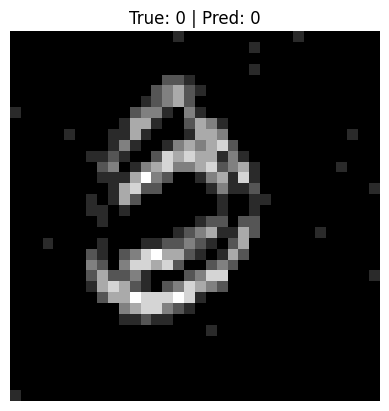

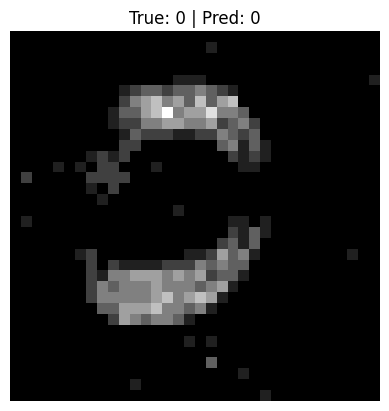

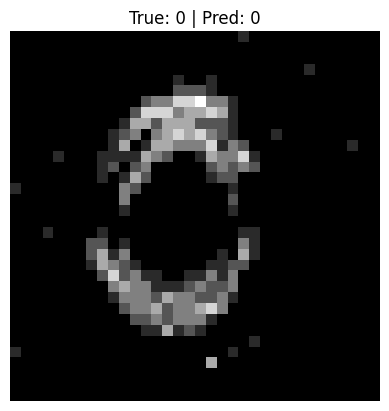

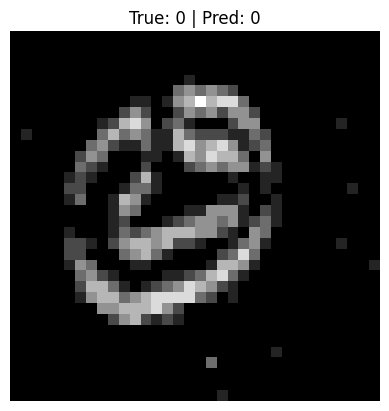

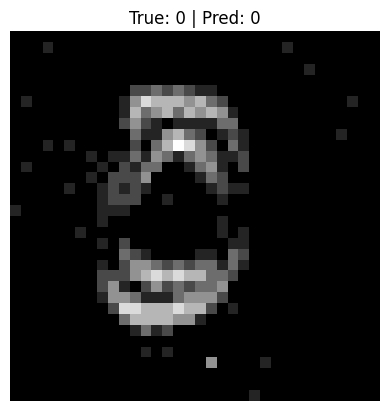


=== CNN_FilteredTemporal ===


[CNN_FilteredTemporal] Epoch 1: Test Acc 58.71% | Red 85.76% | Batch 20.2 ms


[CNN_FilteredTemporal] Epoch 2: Test Acc 65.79% | Red 85.76% | Batch 19.7 ms


[CNN_FilteredTemporal] Epoch 3: Test Acc 69.00% | Red 85.76% | Batch 19.8 ms


[CNN_FilteredTemporal] Epoch 4: Test Acc 71.42% | Red 85.76% | Batch 19.5 ms


[CNN_FilteredTemporal] Epoch 5: Test Acc 73.24% | Red 85.76% | Batch 19.8 ms


[CNN_FilteredTemporal] Epoch 6: Test Acc 74.34% | Red 85.76% | Batch 19.5 ms


[CNN_FilteredTemporal] Epoch 7: Test Acc 75.86% | Red 85.76% | Batch 19.5 ms


[CNN_FilteredTemporal] Epoch 8: Test Acc 76.80% | Red 85.76% | Batch 19.8 ms


[CNN_FilteredTemporal] Epoch 9: Test Acc 78.07% | Red 85.76% | Batch 19.2 ms


[CNN_FilteredTemporal] Epoch 10: Test Acc 78.17% | Red 85.76% | Batch 19.7 ms


[CNN_FilteredTemporal] Epoch 11: Test Acc 79.08% | Red 85.76% | Batch 19.8 ms


[CNN_FilteredTemporal] Epoch 12: Test Acc 80.13% | Red 85.76% | Batch 20.2 ms


[CNN_FilteredTemporal] Epoch 13: Test Acc 79.69% | Red 85.76% | Batch 19.3 ms


[CNN_FilteredTemporal] Epoch 14: Test Acc 80.88% | Red 85.76% | Batch 19.1 ms


[CNN_FilteredTemporal] Epoch 15: Test Acc 80.87% | Red 85.76% | Batch 19.4 ms


[CNN_FilteredTemporal] Epoch 16: Test Acc 81.64% | Red 85.76% | Batch 19.7 ms


[CNN_FilteredTemporal] Epoch 17: Test Acc 81.15% | Red 85.76% | Batch 19.4 ms


[CNN_FilteredTemporal] Epoch 18: Test Acc 82.33% | Red 85.76% | Batch 19.6 ms


[CNN_FilteredTemporal] Epoch 19: Test Acc 81.86% | Red 85.76% | Batch 19.3 ms


[CNN_FilteredTemporal] Epoch 20: Test Acc 82.60% | Red 85.76% | Batch 19.8 ms

--- Inference Samples: CNN_FilteredTemporal ---


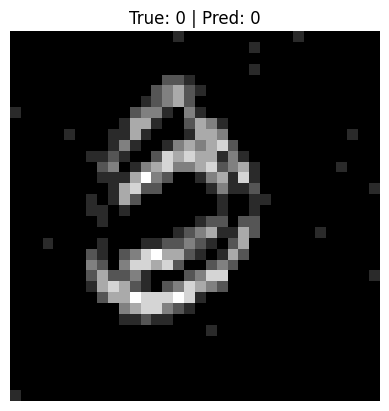

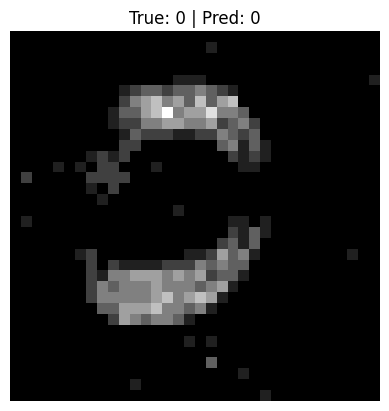

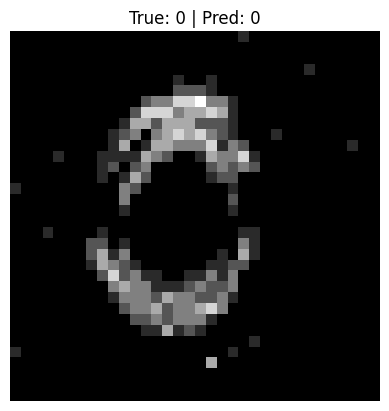

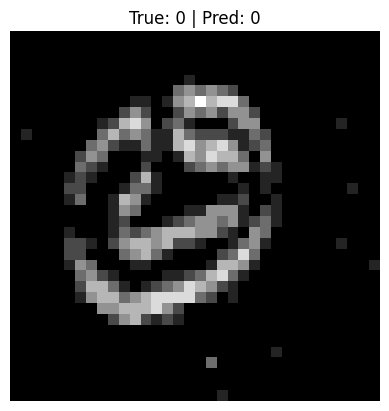

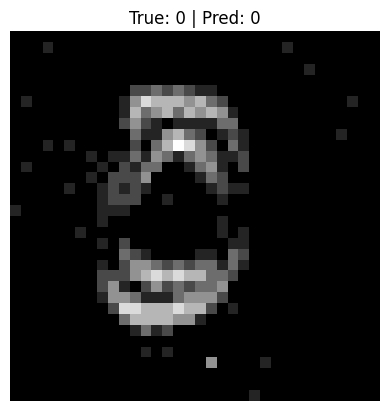


=== SNN_Full ===


[SNN_Full] Epoch 1: Test Acc 71.07% | Red 0.00% | Batch 29.5 ms


[SNN_Full] Epoch 2: Test Acc 69.46% | Red 0.00% | Batch 28.4 ms


[SNN_Full] Epoch 3: Test Acc 70.05% | Red 0.00% | Batch 29.2 ms


[SNN_Full] Epoch 4: Test Acc 66.49% | Red 0.00% | Batch 29.3 ms


[SNN_Full] Epoch 5: Test Acc 66.30% | Red 0.00% | Batch 28.4 ms


[SNN_Full] Epoch 6: Test Acc 63.12% | Red 0.00% | Batch 29.1 ms


[SNN_Full] Epoch 7: Test Acc 63.29% | Red 0.00% | Batch 29.8 ms


[SNN_Full] Epoch 8: Test Acc 63.27% | Red 0.00% | Batch 29.8 ms


[SNN_Full] Epoch 9: Test Acc 57.06% | Red 0.00% | Batch 28.8 ms
Early stopping triggered.

--- Inference Samples: SNN_Full ---


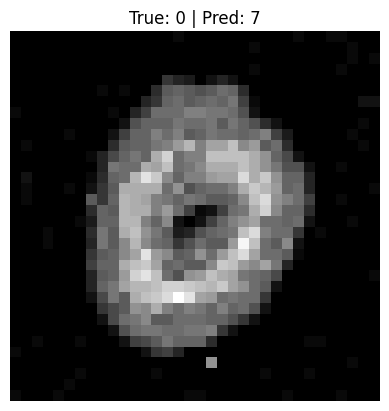

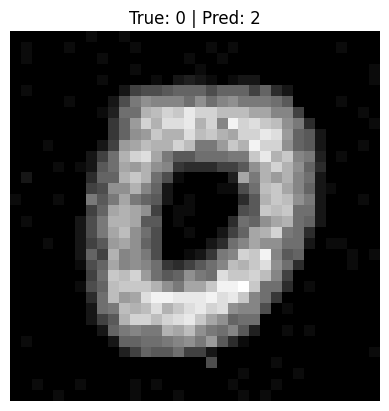

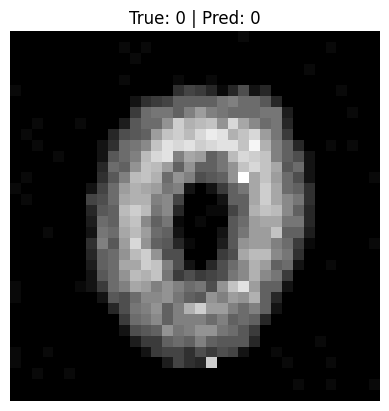

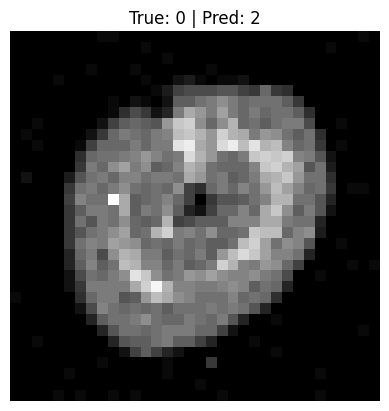

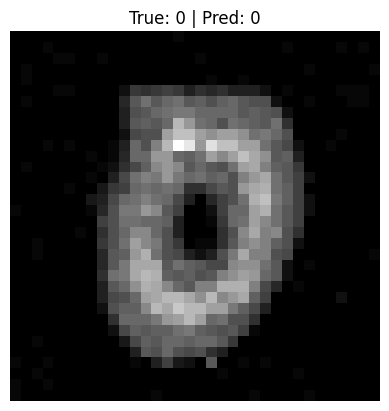


=== SNN_FilteredTemporal ===


[SNN_FilteredTemporal] Epoch 1: Test Acc 48.36% | Red 85.76% | Batch 40.5 ms


[SNN_FilteredTemporal] Epoch 2: Test Acc 47.10% | Red 85.76% | Batch 41.2 ms


[SNN_FilteredTemporal] Epoch 3: Test Acc 45.20% | Red 85.76% | Batch 43.8 ms


[SNN_FilteredTemporal] Epoch 4: Test Acc 45.26% | Red 85.76% | Batch 42.2 ms


[SNN_FilteredTemporal] Epoch 5: Test Acc 42.25% | Red 85.76% | Batch 42.3 ms


[SNN_FilteredTemporal] Epoch 6: Test Acc 44.86% | Red 85.76% | Batch 41.8 ms


[SNN_FilteredTemporal] Epoch 7: Test Acc 42.47% | Red 85.76% | Batch 40.8 ms


[SNN_FilteredTemporal] Epoch 8: Test Acc 39.56% | Red 85.76% | Batch 40.7 ms


[SNN_FilteredTemporal] Epoch 9: Test Acc 42.31% | Red 85.76% | Batch 41.0 ms
Early stopping triggered.

--- Inference Samples: SNN_FilteredTemporal ---


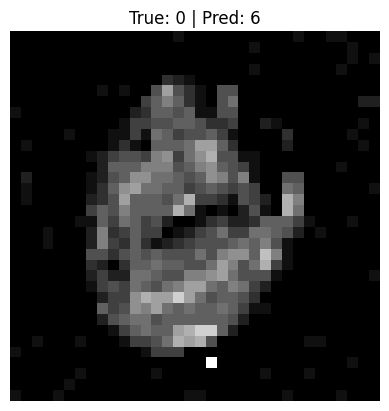

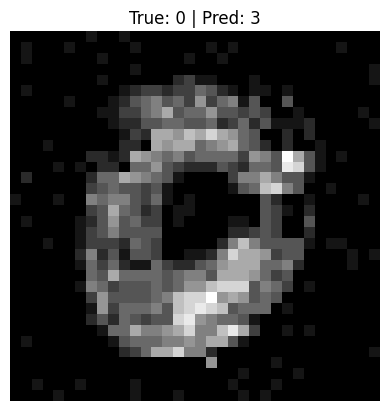

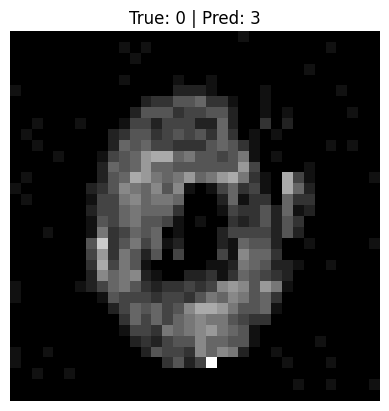

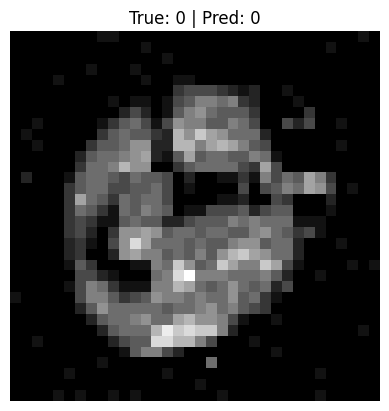

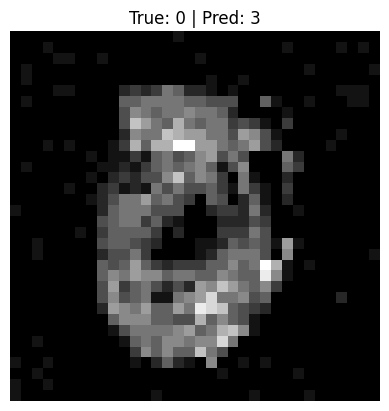


=== Results ===
CNN_Full {'best_acc': 97.33, 'event_reduction_%': 0.0, 'avg_batch_time_s': 0.0016175394604919823}
CNN_FilteredTemporal {'best_acc': 82.6, 'event_reduction_%': 85.75759348186236, 'avg_batch_time_s': 0.019825046988809186}
SNN_Full {'best_acc': 71.07, 'event_reduction_%': 0.0, 'avg_batch_time_s': 0.02876789402809872}
SNN_FilteredTemporal {'best_acc': 48.36, 'event_reduction_%': 85.75759348186236, 'avg_batch_time_s': 0.0409724849044897}


,best_acc,event_reduction_%,avg_batch_time_s
config,,,
CNN_Full,97.33,0.000000,0.001618
CNN_FilteredTemporal,82.60,85.757593,0.019825
SNN_Full,71.07,0.000000,0.028768
SNN_FilteredTemporal,48.36,85.757593,0.040972


Saved: results_full_vs_temporal.csv


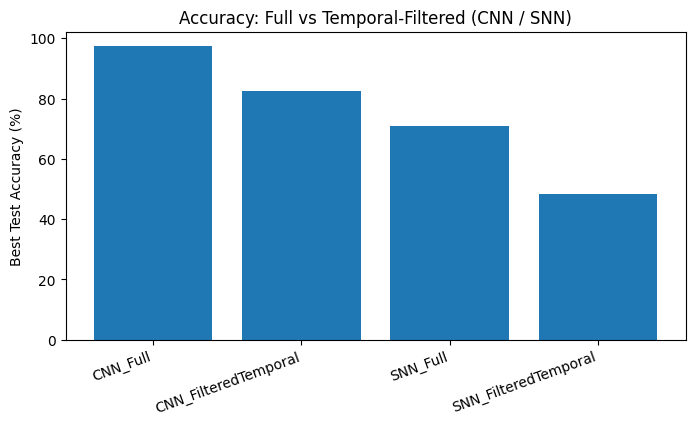

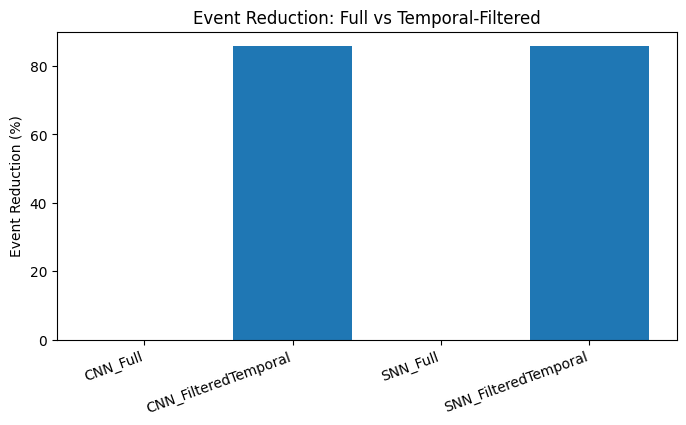

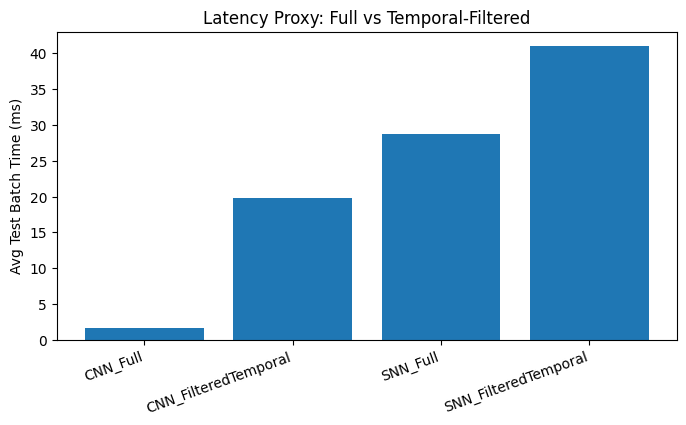

In [9]:
@torch.no_grad()
def inference_visualization(model, loader, is_snn=False, roi_model=None,
                            threshold=None, percentile=None, num_samples=5):
    model.eval()
    if roi_model is not None:
        roi_model.eval()

    data, targets = next(iter(loader))
    data, targets = data.to(device), targets.to(device)

    # Apply ROI if provided
    if roi_model is not None:
        masks = roi_model(data)
        data  = apply_roi_filter(
            data, masks,
            threshold=(threshold if percentile is None else 0.0),
            percentile=percentile
        )

    # Forward pass (SNN consumes full sequence; CNN gets time-mean)
    outputs = model(data if is_snn else data.mean(dim=1))
    _, predicted = outputs.max(1)

    # Visualize a consistent 2D grayscale frame
    for i in range(min(num_samples, data.size(0))):
        if is_snn:
            # data[i] -> (T, 1, H, W) -> mean over time -> (1, H, W) -> squeeze C -> (H, W)
            img2d = data[i].mean(dim=0).squeeze(0)
        else:
            # data[i, 0] -> (1, H, W) (first time step) -> squeeze C -> (H, W)
            img2d = data[i, 0].squeeze(0)

        plt.imshow(img2d.detach().cpu(), cmap='gray')
        plt.title(f"True: {targets[i].item()} | Pred: {predicted[i].item()}")
        plt.axis('off')
        plt.show()

    # Cleanup
    del data, targets, outputs
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

def run_experiment_full_vs_filtered(trainloader, testloader, num_classes,
                                    max_epochs_cnn=20, patience_cnn=3, lr_cnn=1e-3,
                                    max_epochs_snn=35, patience_snn=8, lr_snn=3e-4):
    results = {}
    criterion = nn.CrossEntropyLoss()

    configs = [
        ("CNN_Full", False, None,  max_epochs_cnn, patience_cnn, lr_cnn),
        ("CNN_FilteredTemporal", False, roi_temporal, max_epochs_cnn, patience_cnn, lr_cnn),
        ("SNN_Full", True, None,  max_epochs_snn, patience_snn, lr_snn),
        ("SNN_FilteredTemporal", True, roi_temporal, max_epochs_snn, patience_snn, lr_snn),
    ]

    for name, is_snn, roi_model, max_epochs, patience, lr in configs:
        print(f"\n=== {name} ===")
        model = (LeNetSNN(num_classes).to(device) if is_snn else LeNetCNN(num_classes).to(device))
        optimizer = optim.Adam(model.parameters(), lr=lr)
        stopper = EarlyStopper(patience=patience)

        last_te_red = 0.0
        last_te_bt  = 0.0
        use_pct = (ROI_PERCENTILE if ROI_USE_PERCENTILE and roi_model is not None else None)

        try:
            for epoch in range(max_epochs):
                tr_loss, tr_acc, tr_red, tr_bt = train_epoch(
                    model, trainloader, criterion, optimizer, is_snn, roi_model,
                    percentile=use_pct, tag=name
                )
                te_loss, te_acc, te_red, te_bt = test_epoch(
                    model, testloader, criterion, is_snn, roi_model,
                    percentile=use_pct, tag=name
                )
                last_te_red, last_te_bt = te_red, te_bt
                print(f"[{name}] Epoch {epoch+1}: Test Acc {te_acc:.2f}% | Red {te_red:.2f}% | Batch {te_bt*1000:.1f} ms")

                if stopper.step(te_acc):
                    print("Early stopping triggered.")
                    break
        except RuntimeError as e:
            print(f"\n[ERROR in {name}] {e}")
            del model, optimizer
            if torch.cuda.is_available(): torch.cuda.empty_cache()
            raise

        results[name] = {
            "best_acc": stopper.best_acc,
            "event_reduction_%": last_te_red,
            "avg_batch_time_s": last_te_bt,
        }

        print(f"\n--- Inference Samples: {name} ---")
        inference_visualization(model, testloader, is_snn=is_snn, roi_model=roi_model,
                                percentile=use_pct, num_samples=5)

        del model, optimizer
        gc.collect()
        if torch.cuda.is_available(): torch.cuda.empty_cache()

    return results

# Run
exp_results = run_experiment_full_vs_filtered(
    trainloader_nm, testloader_nm, num_classes=10,
    max_epochs_cnn=20, patience_cnn=3, lr_cnn=1e-3,
    max_epochs_snn=35, patience_snn=8, lr_snn=3e-4
)

print("\n=== Results ===")
for k, v in exp_results.items():
    print(k, v)

df = pd.DataFrame.from_dict(exp_results, orient='index')
df.index.name = 'config'
display(df)

# Save CSV for Overleaf/appendix
csv_path = 'results_full_vs_temporal.csv'
df.to_csv(csv_path)
print("Saved:", csv_path)

# --- Quick plots ---
plt.figure(figsize=(8,4))
plt.bar(df.index, df['best_acc'])
plt.xticks(rotation=20, ha='right')
plt.ylabel('Best Test Accuracy (%)')
plt.title('Accuracy: Full vs Temporal-Filtered (CNN / SNN)')
plt.show()

plt.figure(figsize=(8,4))
plt.bar(df.index, df['event_reduction_%'])
plt.xticks(rotation=20, ha='right')
plt.ylabel('Event Reduction (%)')
plt.title('Event Reduction: Full vs Temporal-Filtered')
plt.show()

plt.figure(figsize=(8,4))
plt.bar(df.index, df['avg_batch_time_s']*1000.0)
plt.xticks(rotation=20, ha='right')
plt.ylabel('Avg Test Batch Time (ms)')
plt.title('Latency Proxy: Full vs Temporal-Filtered')
plt.show()

In [10]:
# percentiles = fraction kept per (B,T) frame
PERCENTILES = (0.05, 0.10, 0.15, 0.20, 0.30, 0.50, 0.70)
print("Percentiles to sweep (keep-top-p):", PERCENTILES)

Percentiles to sweep (keep-top-p): (0.05, 0.1, 0.15, 0.2, 0.3, 0.5, 0.7)


In [11]:
def run_single_temporal_pct(trainloader, testloader, num_classes, model_kind, keep_pct,
                            max_epochs_cnn=12, patience_cnn=3, lr_cnn=1e-3,
                            max_epochs_snn=20, patience_snn=6, lr_snn=3e-4):
    """Train + test one configuration with Temporal ROI Lite at given percentile."""
    assert model_kind.lower() in ("cnn", "snn")
    is_snn = (model_kind.lower() == "snn")

    # model + hyperparams per backbone
    if is_snn:
        model = LeNetSNN(num_classes).to(device)
        max_epochs, patience, lr = max_epochs_snn, patience_snn, lr_snn
    else:
        model = LeNetCNN(num_classes).to(device)
        max_epochs, patience, lr = max_epochs_cnn, patience_cnn, lr_cnn

    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # fresh ROI instance per run (fair + isolates randomness)
    roi = SpikingRNNROI_Temporal().to(device)

    stopper = EarlyStopper(patience=patience)
    last_te_red = 0.0
    last_te_bt  = 0.0

    for epoch in range(max_epochs):
        tr_loss, tr_acc, tr_red, tr_bt = train_epoch(
            model, trainloader, criterion, optimizer,
            is_snn=is_snn, roi_model=roi, percentile=keep_pct
        )
        te_loss, te_acc, te_red, te_bt = test_epoch(
            model, testloader, criterion,
            is_snn=is_snn, roi_model=roi, percentile=keep_pct
        )
        last_te_red, last_te_bt = te_red, te_bt

        print(f"[{model_kind.upper()} | keep={keep_pct:.2f}] "
              f"Epoch {epoch+1}: Test Acc {te_acc:.2f}% | Red {te_red:.2f}% | Batch {te_bt*1000:.1f} ms")

        if stopper.step(te_acc):
            print("  Early stopping.")
            break

    out = {
        "model": model_kind.upper(),
        "keep_percentile": keep_pct,
        "best_acc": stopper.best_acc,
        "event_reduction_%": last_te_red,
        "avg_batch_time_s": last_te_bt,
    }

    del model, optimizer, roi
    gc.collect()
    if torch.cuda.is_available(): torch.cuda.empty_cache()

    return out


def sweep_temporal_percentiles(trainloader, testloader, num_classes,
                               percentiles=PERCENTILES,
                               max_epochs_cnn=12, patience_cnn=3, lr_cnn=1e-3,
                               max_epochs_snn=20, patience_snn=6, lr_snn=3e-4):
    """Runs Temporal ROI for both CNN & SNN across a list of keep‑percentiles.
       Also runs a full (no ROI) baseline once per model."""
    rows = []

    # Baselines (no ROI)
    for model_kind in ["cnn", "snn"]:
        print(f"\n=== {model_kind.upper()}_Full (baseline, no ROI) ===")
        is_snn = (model_kind == "snn")
        if is_snn:
            model = LeNetSNN(num_classes).to(device)
            max_epochs, patience, lr = max_epochs_snn, patience_snn, lr_snn
        else:
            model = LeNetCNN(num_classes).to(device)
            max_epochs, patience, lr = max_epochs_cnn, patience_cnn, lr_cnn

        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()
        stopper = EarlyStopper(patience=patience)

        last_te_bt = 0.0
        for epoch in range(max_epochs):
            tr_loss, tr_acc, _, tr_bt = train_epoch(model, trainloader, criterion, optimizer,
                                                    is_snn=is_snn, roi_model=None, percentile=None)
            te_loss, te_acc, _, te_bt = test_epoch(model, testloader, criterion,
                                                   is_snn=is_snn, roi_model=None, percentile=None)
            last_te_bt = te_bt
            print(f"[{model_kind.upper()} | full] Epoch {epoch+1}: Test Acc {te_acc:.2f}% | Batch {te_bt*1000:.1f} ms")
            if stopper.step(te_acc):
                print("  Early stopping.")
                break

        rows.append({
            "model": model_kind.upper(),
            "keep_percentile": None,
            "best_acc": stopper.best_acc,
            "event_reduction_%": 0.0,
            "avg_batch_time_s": last_te_bt,
        })

        del model, optimizer
        gc.collect()
        if torch.cuda.is_available(): torch.cuda.empty_cache()

    # Temporal ROI percentile sweep
    for p in percentiles:
        for model_kind in ["cnn", "snn"]:
            print(f"\n=== TEMPORAL ROI SWEEP: {model_kind.upper()} keep={p:.2f} ===")
            res = run_single_temporal_pct(trainloader, testloader, num_classes, model_kind, p,
                                          max_epochs_cnn=max_epochs_cnn, patience_cnn=patience_cnn, lr_cnn=lr_cnn,
                                          max_epochs_snn=max_epochs_snn, patience_snn=patience_snn, lr_snn=lr_snn)
            rows.append(res)

    df = pd.DataFrame(rows)
    return df.sort_values(by=["model", "keep_percentile"], na_position="first")


=== CNN_Full (baseline, no ROI) ===


[CNN | full] Epoch 1: Test Acc 92.28% | Batch 1.4 ms


[CNN | full] Epoch 2: Test Acc 93.88% | Batch 1.4 ms


[CNN | full] Epoch 3: Test Acc 95.26% | Batch 1.3 ms


[CNN | full] Epoch 4: Test Acc 96.17% | Batch 1.3 ms


[CNN | full] Epoch 5: Test Acc 96.61% | Batch 1.4 ms


[CNN | full] Epoch 6: Test Acc 96.66% | Batch 1.4 ms


[CNN | full] Epoch 7: Test Acc 96.95% | Batch 1.3 ms


[CNN | full] Epoch 8: Test Acc 96.56% | Batch 1.4 ms


[CNN | full] Epoch 9: Test Acc 96.90% | Batch 1.3 ms


[CNN | full] Epoch 10: Test Acc 97.32% | Batch 1.3 ms


[CNN | full] Epoch 11: Test Acc 97.38% | Batch 1.3 ms


[CNN | full] Epoch 12: Test Acc 96.69% | Batch 1.4 ms

=== SNN_Full (baseline, no ROI) ===


[SNN | full] Epoch 1: Test Acc 70.92% | Batch 28.5 ms


[SNN | full] Epoch 2: Test Acc 67.39% | Batch 28.5 ms


[SNN | full] Epoch 3: Test Acc 65.86% | Batch 28.9 ms


[SNN | full] Epoch 4: Test Acc 65.90% | Batch 28.2 ms


[SNN | full] Epoch 5: Test Acc 66.24% | Batch 28.9 ms


[SNN | full] Epoch 6: Test Acc 66.19% | Batch 32.5 ms


[SNN | full] Epoch 7: Test Acc 64.73% | Batch 30.1 ms
  Early stopping.

=== TEMPORAL ROI SWEEP: CNN keep=0.05 ===


[CNN | keep=0.05] Epoch 1: Test Acc 68.46% | Red 86.05% | Batch 19.4 ms


[CNN | keep=0.05] Epoch 2: Test Acc 73.03% | Red 86.05% | Batch 19.0 ms


[CNN | keep=0.05] Epoch 3: Test Acc 76.23% | Red 86.05% | Batch 19.2 ms


[CNN | keep=0.05] Epoch 4: Test Acc 77.22% | Red 86.05% | Batch 19.0 ms


[CNN | keep=0.05] Epoch 5: Test Acc 78.03% | Red 86.05% | Batch 21.0 ms


[CNN | keep=0.05] Epoch 6: Test Acc 79.28% | Red 86.05% | Batch 19.2 ms


[CNN | keep=0.05] Epoch 7: Test Acc 79.15% | Red 86.05% | Batch 19.5 ms


[CNN | keep=0.05] Epoch 8: Test Acc 80.04% | Red 86.05% | Batch 19.4 ms


[CNN | keep=0.05] Epoch 9: Test Acc 80.68% | Red 86.05% | Batch 22.6 ms


[CNN | keep=0.05] Epoch 10: Test Acc 81.85% | Red 86.05% | Batch 19.1 ms


[CNN | keep=0.05] Epoch 11: Test Acc 81.93% | Red 86.05% | Batch 19.0 ms


[CNN | keep=0.05] Epoch 12: Test Acc 82.23% | Red 86.05% | Batch 19.3 ms

=== TEMPORAL ROI SWEEP: SNN keep=0.05 ===


[SNN | keep=0.05] Epoch 1: Test Acc 63.28% | Red 86.86% | Batch 41.9 ms


[SNN | keep=0.05] Epoch 2: Test Acc 57.51% | Red 86.86% | Batch 41.5 ms


[SNN | keep=0.05] Epoch 3: Test Acc 56.91% | Red 86.86% | Batch 41.5 ms


[SNN | keep=0.05] Epoch 4: Test Acc 55.15% | Red 86.86% | Batch 41.9 ms


[SNN | keep=0.05] Epoch 5: Test Acc 54.68% | Red 86.86% | Batch 44.0 ms


[SNN | keep=0.05] Epoch 6: Test Acc 51.85% | Red 86.86% | Batch 40.8 ms


[SNN | keep=0.05] Epoch 7: Test Acc 49.61% | Red 86.86% | Batch 39.8 ms
  Early stopping.

=== TEMPORAL ROI SWEEP: CNN keep=0.10 ===


[CNN | keep=0.10] Epoch 1: Test Acc 75.63% | Red 84.81% | Batch 18.6 ms


[CNN | keep=0.10] Epoch 2: Test Acc 80.00% | Red 84.81% | Batch 19.0 ms


[CNN | keep=0.10] Epoch 3: Test Acc 83.70% | Red 84.81% | Batch 19.0 ms


[CNN | keep=0.10] Epoch 4: Test Acc 83.48% | Red 84.81% | Batch 19.4 ms


[CNN | keep=0.10] Epoch 5: Test Acc 84.64% | Red 84.81% | Batch 19.0 ms


[CNN | keep=0.10] Epoch 6: Test Acc 84.53% | Red 84.81% | Batch 19.1 ms


[CNN | keep=0.10] Epoch 7: Test Acc 85.83% | Red 84.81% | Batch 19.0 ms


[CNN | keep=0.10] Epoch 8: Test Acc 86.08% | Red 84.81% | Batch 19.2 ms


[CNN | keep=0.10] Epoch 9: Test Acc 85.73% | Red 84.81% | Batch 19.3 ms


[CNN | keep=0.10] Epoch 10: Test Acc 87.18% | Red 84.81% | Batch 19.2 ms


[CNN | keep=0.10] Epoch 11: Test Acc 86.78% | Red 84.81% | Batch 19.1 ms


[CNN | keep=0.10] Epoch 12: Test Acc 86.66% | Red 84.81% | Batch 18.6 ms

=== TEMPORAL ROI SWEEP: SNN keep=0.10 ===


[SNN | keep=0.10] Epoch 1: Test Acc 60.35% | Red 80.53% | Batch 39.7 ms


[SNN | keep=0.10] Epoch 2: Test Acc 57.73% | Red 80.53% | Batch 40.9 ms


[SNN | keep=0.10] Epoch 3: Test Acc 53.65% | Red 80.53% | Batch 40.8 ms


[SNN | keep=0.10] Epoch 4: Test Acc 51.07% | Red 80.53% | Batch 44.1 ms


[SNN | keep=0.10] Epoch 5: Test Acc 55.17% | Red 80.53% | Batch 40.1 ms


[SNN | keep=0.10] Epoch 6: Test Acc 49.92% | Red 80.53% | Batch 44.0 ms


[SNN | keep=0.10] Epoch 7: Test Acc 47.99% | Red 80.53% | Batch 43.6 ms
  Early stopping.

=== TEMPORAL ROI SWEEP: CNN keep=0.15 ===


[CNN | keep=0.15] Epoch 1: Test Acc 84.09% | Red 67.14% | Batch 19.4 ms


[CNN | keep=0.15] Epoch 2: Test Acc 86.78% | Red 67.14% | Batch 19.2 ms


[CNN | keep=0.15] Epoch 3: Test Acc 87.82% | Red 67.14% | Batch 19.3 ms


[CNN | keep=0.15] Epoch 4: Test Acc 89.39% | Red 67.14% | Batch 19.3 ms


[CNN | keep=0.15] Epoch 5: Test Acc 89.61% | Red 67.14% | Batch 18.6 ms


[CNN | keep=0.15] Epoch 6: Test Acc 89.08% | Red 67.14% | Batch 19.0 ms


[CNN | keep=0.15] Epoch 7: Test Acc 90.06% | Red 67.14% | Batch 19.0 ms


[CNN | keep=0.15] Epoch 8: Test Acc 90.45% | Red 67.14% | Batch 18.7 ms


[CNN | keep=0.15] Epoch 9: Test Acc 91.02% | Red 67.14% | Batch 19.5 ms


[CNN | keep=0.15] Epoch 10: Test Acc 90.92% | Red 67.14% | Batch 19.5 ms


[CNN | keep=0.15] Epoch 11: Test Acc 91.42% | Red 67.14% | Batch 19.1 ms


[CNN | keep=0.15] Epoch 12: Test Acc 91.38% | Red 67.14% | Batch 18.7 ms

=== TEMPORAL ROI SWEEP: SNN keep=0.15 ===


[SNN | keep=0.15] Epoch 1: Test Acc 73.00% | Red 50.22% | Batch 41.2 ms


[SNN | keep=0.15] Epoch 2: Test Acc 71.00% | Red 50.22% | Batch 41.6 ms


[SNN | keep=0.15] Epoch 3: Test Acc 63.85% | Red 50.22% | Batch 44.7 ms


[SNN | keep=0.15] Epoch 4: Test Acc 63.92% | Red 50.22% | Batch 41.4 ms


[SNN | keep=0.15] Epoch 5: Test Acc 61.71% | Red 50.22% | Batch 41.7 ms


[SNN | keep=0.15] Epoch 6: Test Acc 54.91% | Red 50.22% | Batch 41.2 ms


[SNN | keep=0.15] Epoch 7: Test Acc 56.86% | Red 50.22% | Batch 41.6 ms
  Early stopping.

=== TEMPORAL ROI SWEEP: CNN keep=0.20 ===


[CNN | keep=0.20] Epoch 1: Test Acc 73.12% | Red 74.37% | Batch 19.6 ms


[CNN | keep=0.20] Epoch 2: Test Acc 77.42% | Red 74.37% | Batch 19.0 ms


[CNN | keep=0.20] Epoch 3: Test Acc 79.51% | Red 74.37% | Batch 19.7 ms


[CNN | keep=0.20] Epoch 4: Test Acc 81.64% | Red 74.37% | Batch 18.9 ms


[CNN | keep=0.20] Epoch 5: Test Acc 81.90% | Red 74.37% | Batch 19.0 ms


[CNN | keep=0.20] Epoch 6: Test Acc 82.58% | Red 74.37% | Batch 19.3 ms


[CNN | keep=0.20] Epoch 7: Test Acc 82.75% | Red 74.37% | Batch 19.3 ms


[CNN | keep=0.20] Epoch 8: Test Acc 83.86% | Red 74.37% | Batch 18.9 ms


[CNN | keep=0.20] Epoch 9: Test Acc 84.88% | Red 74.37% | Batch 18.9 ms


[CNN | keep=0.20] Epoch 10: Test Acc 84.82% | Red 74.37% | Batch 19.2 ms


[CNN | keep=0.20] Epoch 11: Test Acc 84.41% | Red 74.37% | Batch 19.6 ms


[CNN | keep=0.20] Epoch 12: Test Acc 86.17% | Red 74.37% | Batch 20.7 ms

=== TEMPORAL ROI SWEEP: SNN keep=0.20 ===


[SNN | keep=0.20] Epoch 1: Test Acc 68.56% | Red 58.05% | Batch 41.0 ms


[SNN | keep=0.20] Epoch 2: Test Acc 66.02% | Red 58.05% | Batch 41.2 ms


[SNN | keep=0.20] Epoch 3: Test Acc 65.30% | Red 58.05% | Batch 42.7 ms


[SNN | keep=0.20] Epoch 4: Test Acc 60.11% | Red 58.05% | Batch 41.0 ms


[SNN | keep=0.20] Epoch 5: Test Acc 57.26% | Red 58.05% | Batch 42.9 ms


[SNN | keep=0.20] Epoch 6: Test Acc 52.96% | Red 58.05% | Batch 41.8 ms


[SNN | keep=0.20] Epoch 7: Test Acc 52.81% | Red 58.05% | Batch 41.3 ms
  Early stopping.

=== TEMPORAL ROI SWEEP: CNN keep=0.30 ===


[CNN | keep=0.30] Epoch 1: Test Acc 88.37% | Red 36.84% | Batch 19.4 ms


[CNN | keep=0.30] Epoch 2: Test Acc 91.95% | Red 36.84% | Batch 18.9 ms


[CNN | keep=0.30] Epoch 3: Test Acc 92.64% | Red 36.84% | Batch 19.1 ms


[CNN | keep=0.30] Epoch 4: Test Acc 93.46% | Red 36.84% | Batch 19.2 ms


[CNN | keep=0.30] Epoch 5: Test Acc 94.17% | Red 36.84% | Batch 19.5 ms


[CNN | keep=0.30] Epoch 6: Test Acc 94.33% | Red 36.84% | Batch 19.2 ms


[CNN | keep=0.30] Epoch 7: Test Acc 94.20% | Red 36.84% | Batch 19.1 ms


[CNN | keep=0.30] Epoch 8: Test Acc 94.98% | Red 36.84% | Batch 19.1 ms


[CNN | keep=0.30] Epoch 9: Test Acc 94.95% | Red 36.84% | Batch 19.3 ms


[CNN | keep=0.30] Epoch 10: Test Acc 95.05% | Red 36.84% | Batch 19.3 ms


[CNN | keep=0.30] Epoch 11: Test Acc 95.06% | Red 36.84% | Batch 19.6 ms


[CNN | keep=0.30] Epoch 12: Test Acc 95.03% | Red 36.84% | Batch 19.5 ms

=== TEMPORAL ROI SWEEP: SNN keep=0.30 ===


[SNN | keep=0.30] Epoch 1: Test Acc 51.03% | Red 90.60% | Batch 45.7 ms


[SNN | keep=0.30] Epoch 2: Test Acc 47.21% | Red 90.60% | Batch 41.3 ms


[SNN | keep=0.30] Epoch 3: Test Acc 46.14% | Red 90.60% | Batch 42.0 ms


[SNN | keep=0.30] Epoch 4: Test Acc 45.99% | Red 90.60% | Batch 39.8 ms


[SNN | keep=0.30] Epoch 5: Test Acc 47.77% | Red 90.60% | Batch 42.8 ms


[SNN | keep=0.30] Epoch 6: Test Acc 46.92% | Red 90.60% | Batch 40.1 ms


[SNN | keep=0.30] Epoch 7: Test Acc 41.80% | Red 90.60% | Batch 41.0 ms
  Early stopping.

=== TEMPORAL ROI SWEEP: CNN keep=0.50 ===


[CNN | keep=0.50] Epoch 1: Test Acc 88.95% | Red 30.44% | Batch 19.5 ms


[CNN | keep=0.50] Epoch 2: Test Acc 91.43% | Red 30.44% | Batch 19.7 ms


[CNN | keep=0.50] Epoch 3: Test Acc 91.00% | Red 30.44% | Batch 19.4 ms


[CNN | keep=0.50] Epoch 4: Test Acc 93.46% | Red 30.44% | Batch 19.7 ms


[CNN | keep=0.50] Epoch 5: Test Acc 93.69% | Red 30.44% | Batch 18.9 ms


[CNN | keep=0.50] Epoch 6: Test Acc 94.76% | Red 30.44% | Batch 19.4 ms


[CNN | keep=0.50] Epoch 7: Test Acc 94.97% | Red 30.44% | Batch 19.3 ms


[CNN | keep=0.50] Epoch 8: Test Acc 94.93% | Red 30.44% | Batch 19.6 ms


[CNN | keep=0.50] Epoch 9: Test Acc 95.30% | Red 30.44% | Batch 19.9 ms


[CNN | keep=0.50] Epoch 10: Test Acc 95.17% | Red 30.44% | Batch 19.4 ms


[CNN | keep=0.50] Epoch 11: Test Acc 95.30% | Red 30.44% | Batch 19.7 ms


[CNN | keep=0.50] Epoch 12: Test Acc 95.55% | Red 30.44% | Batch 19.3 ms

=== TEMPORAL ROI SWEEP: SNN keep=0.50 ===


[SNN | keep=0.50] Epoch 1: Test Acc 61.81% | Red 61.69% | Batch 42.0 ms


[SNN | keep=0.50] Epoch 2: Test Acc 58.82% | Red 61.69% | Batch 41.6 ms


[SNN | keep=0.50] Epoch 3: Test Acc 54.13% | Red 61.69% | Batch 40.2 ms


[SNN | keep=0.50] Epoch 4: Test Acc 54.56% | Red 61.69% | Batch 43.8 ms


[SNN | keep=0.50] Epoch 5: Test Acc 51.26% | Red 61.69% | Batch 41.5 ms


[SNN | keep=0.50] Epoch 6: Test Acc 48.07% | Red 61.69% | Batch 41.5 ms


[SNN | keep=0.50] Epoch 7: Test Acc 47.55% | Red 61.69% | Batch 41.0 ms
  Early stopping.

=== TEMPORAL ROI SWEEP: CNN keep=0.70 ===


[CNN | keep=0.70] Epoch 1: Test Acc 82.11% | Red 60.06% | Batch 19.2 ms


[CNN | keep=0.70] Epoch 2: Test Acc 87.94% | Red 60.06% | Batch 19.3 ms


[CNN | keep=0.70] Epoch 3: Test Acc 87.32% | Red 60.06% | Batch 19.0 ms


[CNN | keep=0.70] Epoch 4: Test Acc 89.20% | Red 60.06% | Batch 19.4 ms


[CNN | keep=0.70] Epoch 5: Test Acc 90.40% | Red 60.06% | Batch 19.1 ms


[CNN | keep=0.70] Epoch 6: Test Acc 90.75% | Red 60.06% | Batch 19.3 ms


[CNN | keep=0.70] Epoch 7: Test Acc 90.84% | Red 60.06% | Batch 18.9 ms


[CNN | keep=0.70] Epoch 8: Test Acc 91.75% | Red 60.06% | Batch 19.4 ms


[CNN | keep=0.70] Epoch 9: Test Acc 92.14% | Red 60.06% | Batch 21.9 ms


[CNN | keep=0.70] Epoch 10: Test Acc 92.19% | Red 60.06% | Batch 19.5 ms


[CNN | keep=0.70] Epoch 11: Test Acc 92.35% | Red 60.06% | Batch 20.0 ms


[CNN | keep=0.70] Epoch 12: Test Acc 92.80% | Red 60.06% | Batch 19.9 ms

=== TEMPORAL ROI SWEEP: SNN keep=0.70 ===


[SNN | keep=0.70] Epoch 1: Test Acc 70.80% | Red 48.14% | Batch 41.6 ms


[SNN | keep=0.70] Epoch 2: Test Acc 67.37% | Red 48.14% | Batch 43.2 ms


[SNN | keep=0.70] Epoch 3: Test Acc 62.70% | Red 48.14% | Batch 43.3 ms


[SNN | keep=0.70] Epoch 4: Test Acc 69.63% | Red 48.14% | Batch 39.4 ms


[SNN | keep=0.70] Epoch 5: Test Acc 62.20% | Red 48.14% | Batch 41.0 ms


[SNN | keep=0.70] Epoch 6: Test Acc 63.61% | Red 48.14% | Batch 41.3 ms


[SNN | keep=0.70] Epoch 7: Test Acc 56.81% | Red 48.14% | Batch 46.9 ms
  Early stopping.


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,model,keep_percentile,best_acc,event_reduction_%,avg_batch_time_s
0,CNN,NaN,97.38,0.000000,0.001402
2,CNN,0.05,82.23,86.046083,0.019345
4,CNN,0.10,87.18,84.807911,0.018578
6,CNN,0.15,91.42,67.139132,0.018745
8,CNN,0.20,86.17,74.365208,0.020683
10,CNN,0.30,95.06,36.837726,0.019496
12,CNN,0.50,95.55,30.440953,0.019293
14,CNN,0.70,92.80,60.056818,0.019912
1,SNN,NaN,70.92,0.000000,0.030076
3,SNN,0.05,63.28,86.855927,0.039760


Saved: temporal_roi_percentile_sweep.csv


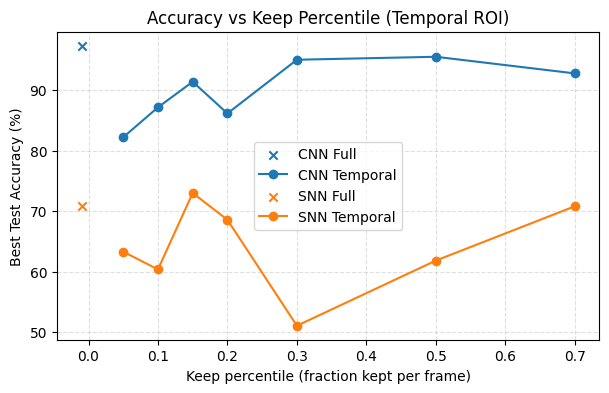

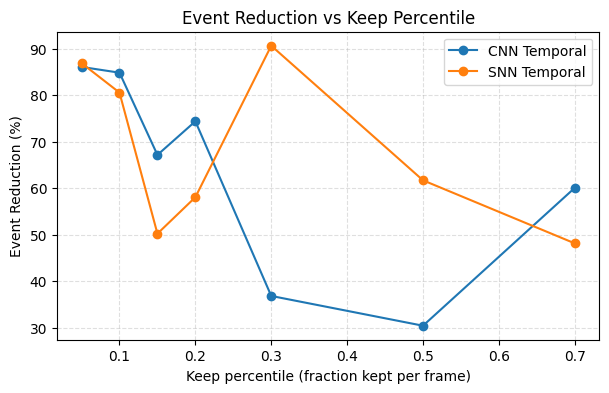

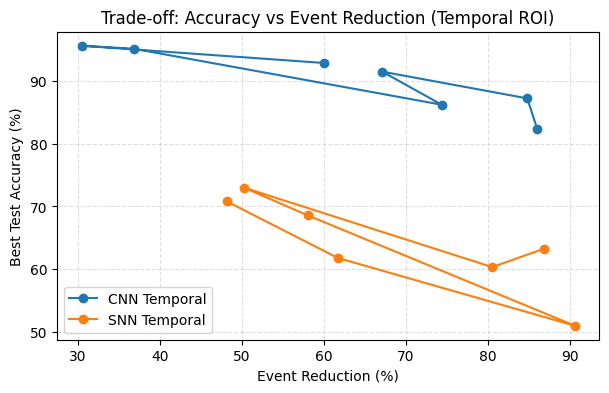

In [12]:
df_pct = sweep_temporal_percentiles(
    trainloader_nm, testloader_nm, num_classes=10,
    percentiles=PERCENTILES,
    max_epochs_cnn=12, patience_cnn=3, lr_cnn=1e-3,
    max_epochs_snn=20, patience_snn=6, lr_snn=3e-4
)

display(df_pct)

# Save CSV for your report
csv_path = "temporal_roi_percentile_sweep.csv"
df_pct.to_csv(csv_path, index=False)
print("Saved:", csv_path)

# --- Plots ---
# Accuracy vs Percentile (fraction kept)
plt.figure(figsize=(7,4))
for mk in ["CNN", "SNN"]:
    sub = df_pct[df_pct["model"]==mk]
    base = sub[sub["keep_percentile"].isna()]
    sw   = sub[sub["keep_percentile"].notna()]
    if not base.empty:
        plt.scatter([-0.01], [base["best_acc"].values[0]], label=f"{mk} Full", marker="x")
    if not sw.empty:
        plt.plot(sw["keep_percentile"], sw["best_acc"], marker="o", label=f"{mk} Temporal")
plt.xlabel("Keep percentile (fraction kept per frame)")
plt.ylabel("Best Test Accuracy (%)")
plt.title("Accuracy vs Keep Percentile (Temporal ROI)")
plt.legend(); plt.grid(True, linestyle="--", alpha=0.4); plt.show()

# Event Reduction vs Percentile
plt.figure(figsize=(7,4))
for mk in ["CNN", "SNN"]:
    sw = df_pct[(df_pct["model"]==mk) & (df_pct["keep_percentile"].notna())]
    if not sw.empty:
        plt.plot(sw["keep_percentile"], sw["event_reduction_%"], marker="o", label=f"{mk} Temporal")
plt.xlabel("Keep percentile (fraction kept per frame)")
plt.ylabel("Event Reduction (%)")
plt.title("Event Reduction vs Keep Percentile")
plt.legend(); plt.grid(True, linestyle="--", alpha=0.4); plt.show()

# Trade-off: Accuracy vs Event Reduction
plt.figure(figsize=(7,4))
for mk in ["CNN", "SNN"]:
    sw = df_pct[(df_pct["model"]==mk) & (df_pct["keep_percentile"].notna())]
    if not sw.empty:
        plt.plot(sw["event_reduction_%"], sw["best_acc"], marker="o", label=f"{mk} Temporal")
plt.xlabel("Event Reduction (%)")
plt.ylabel("Best Test Accuracy (%)")
plt.title("Trade‑off: Accuracy vs Event Reduction (Temporal ROI)")
plt.legend(); plt.grid(True, linestyle="--", alpha=0.4); plt.show()